In [1]:
from collections import OrderedDict, defaultdict
import copy
import itertools
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer.noise import NoiseModel, ReadoutError, QuantumError
from qiskit.providers import Backend
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import CXGate, IGate, RZGate, SXGate, XGate, ZGate, Reset, Measure
from qiskit.circuit import Gate
from helpers import get_error_rate, fit_reverse_gates, get_error_rate_per_qubit
import math
import numpy as np
import os
import pickle
from custom_noise_model_creator import CustomNoiseModelCreator
import datetime
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.colors import LogNorm
from qiskit.providers.ibmq import IBMQ
import pandas as pd
import seaborn as sns

In [2]:
provider = IBMQ.load_account()

In [3]:
class Measurement:
	def __init__(self, circs):
		self.backend_name = None
		self.circuits = circs
		self.noise_model = None
		self.job = None
		self.creator = None
		self.ts = None

	def run(self, backend):
		self.backend_name = backend.name()
		self.ts = datetime.datetime.now()
		self.creator = CustomNoiseModelCreator(backend)
		self.creator.create_test_circuits()
		self.creator.run_circs()
		self.job = backend.run(self.circuits, shots=10000)

		self.noise_model = NoiseModel.from_backend(backend)

In [4]:
folder = "output_long_experiment_creator"
n = 160
measures = []
for i in range(n):
	with open(os.path.join(folder, f"measurement_{i}"), "rb") as file:
		measures.append(pickle.load(file))

In [5]:
measures_per_hw = defaultdict(list)
measures_per_hw_all = defaultdict(list)
for d in measures:
	for k, v in d.items():
		measures_per_hw_all[k].append(v)
		if "RUNNING" in v.job.time_per_step().keys():
			create_completed = v.creator.job.time_per_step()["RUNNING"]
			job_running = v.job.time_per_step()["RUNNING"]
			time_diff = (job_running - create_completed).total_seconds()
			if time_diff > 0:
				measures_per_hw[k].append(v)

In [6]:
def get_hw_error_rate(measures: list[Measurement]):
	errors = []
	for m in measures:
		result_hardware = m.job.result().get_counts()
		error_hardware = np.array([get_error_rate(r, {"00000":1}) for r in result_hardware])
		errors.append(error_hardware)

	return np.array(errors)

In [7]:
def calc_error_from_backend(measures: list[Measurement]):
	errs = []
	for m in measures:
		sim = AerSimulator(noise_model=m.noise_model)

		result = sim.run(m.circuits, shots=10000).result().get_counts()

		error = np.array([get_error_rate(r, {"00000":1}) for r in result])
		
		errs.append(error)

	return np.array(errs)

In [8]:
def calc_error_creator(measures: list[Measurement]):
	errs = []
	for m in measures:
		sim = AerSimulator(noise_model=m.creator.get_custom_noise_model())

		result = sim.run(m.circuits, shots=10000).result().get_counts()

		error = np.array([get_error_rate(r, {"00000":1}) for r in result])

		errs.append(error)

	return np.array(errs)

In [9]:
def get_runtimes(measures: list[Measurement]):
	times = []
	for m in measures:
		job_running = m.job.time_per_step()["RUNNING"]
		times.append(job_running)

	return np.array(times)

In [10]:
def get_runtime_diff(measures: list[Measurement]):
	times = []
	for m in measures:
		create_completed = m.creator.job.time_per_step()["RUNNING"]
		job_running = m.job.time_per_step()["RUNNING"]
		time_diff = (job_running - create_completed).total_seconds()
		if time_diff < 0:
			print(m.creator.job.time_per_step())
			print(m.job.time_per_step())
			print("")
		times.append(time_diff)

	return np.array(times)

In [11]:
def get_time_since_start_in_seconds(measures: list[Measurement]):
	times_seconds = []
	start = measures[0].job.time_per_step()["RUNNING"]
	for m in measures:
		times_seconds.append((m.job.time_per_step()["RUNNING"] - start).total_seconds())

	return np.array(times_seconds)

In [12]:
def get_result_dict(measures_per_hw, hw_name):
	hw_errors = get_hw_error_rate(measures_per_hw[hw_name])
	creator_error = calc_error_creator(measures_per_hw[hw_name])
	from_backend_error = calc_error_from_backend(measures_per_hw[hw_name])

	return {
		"from_backend_err": from_backend_error,
		"creator_err" : creator_error,
		"hw_error" : hw_errors,
		"times" : get_runtimes(measures_per_hw[hw_name]),
		"time_diff" : get_runtime_diff(measures_per_hw[hw_name]),
		"times_seconds" : get_time_since_start_in_seconds(measures_per_hw[hw_name])
	}

In [13]:
# ibmq_manila = get_result_dict(measures_per_hw, "ibmq_manila")

In [14]:
# with open("ibmq_manila_long_creator_test.pickle", "wb") as file:
# 	pickle.dump(ibmq_manila, file)

In [15]:
# ibmq_quito = get_result_dict(measures_per_hw, "ibmq_quito")

In [16]:
# with open("ibmq_quito_long_creator_test.pickle", "wb") as file:
# 	pickle.dump(ibmq_quito, file)

In [17]:
# ibmq_lima = get_result_dict(measures_per_hw, "ibmq_lima")
# ibmq_belem = get_result_dict(measures_per_hw, "ibmq_belem")

In [18]:
with open("ibmq_quito_long_creator_test.pickle", "rb") as file:
	ibmq_quito = pickle.load(file)

with open("ibmq_manila_long_creator_test.pickle", "rb") as file:
	ibmq_manila = pickle.load(file)

In [19]:
#calibration times
#width 5.90666 in

In [20]:
# dates = np.ones_like(ibmq_manila["hw_error"])
# for i in range(dates.shape[1]):
# 	dates[:, i] = ibmq_manila["times_seconds"]
# figure(figsize=(30, 15), dpi=75)
# plt.hist2d(dates.flatten(), ibmq_manila["hw_error"].flatten()*100, bins=(dates[:, 0], np.arange(30, 100, 1)), norm=LogNorm())
# display(plt.show())

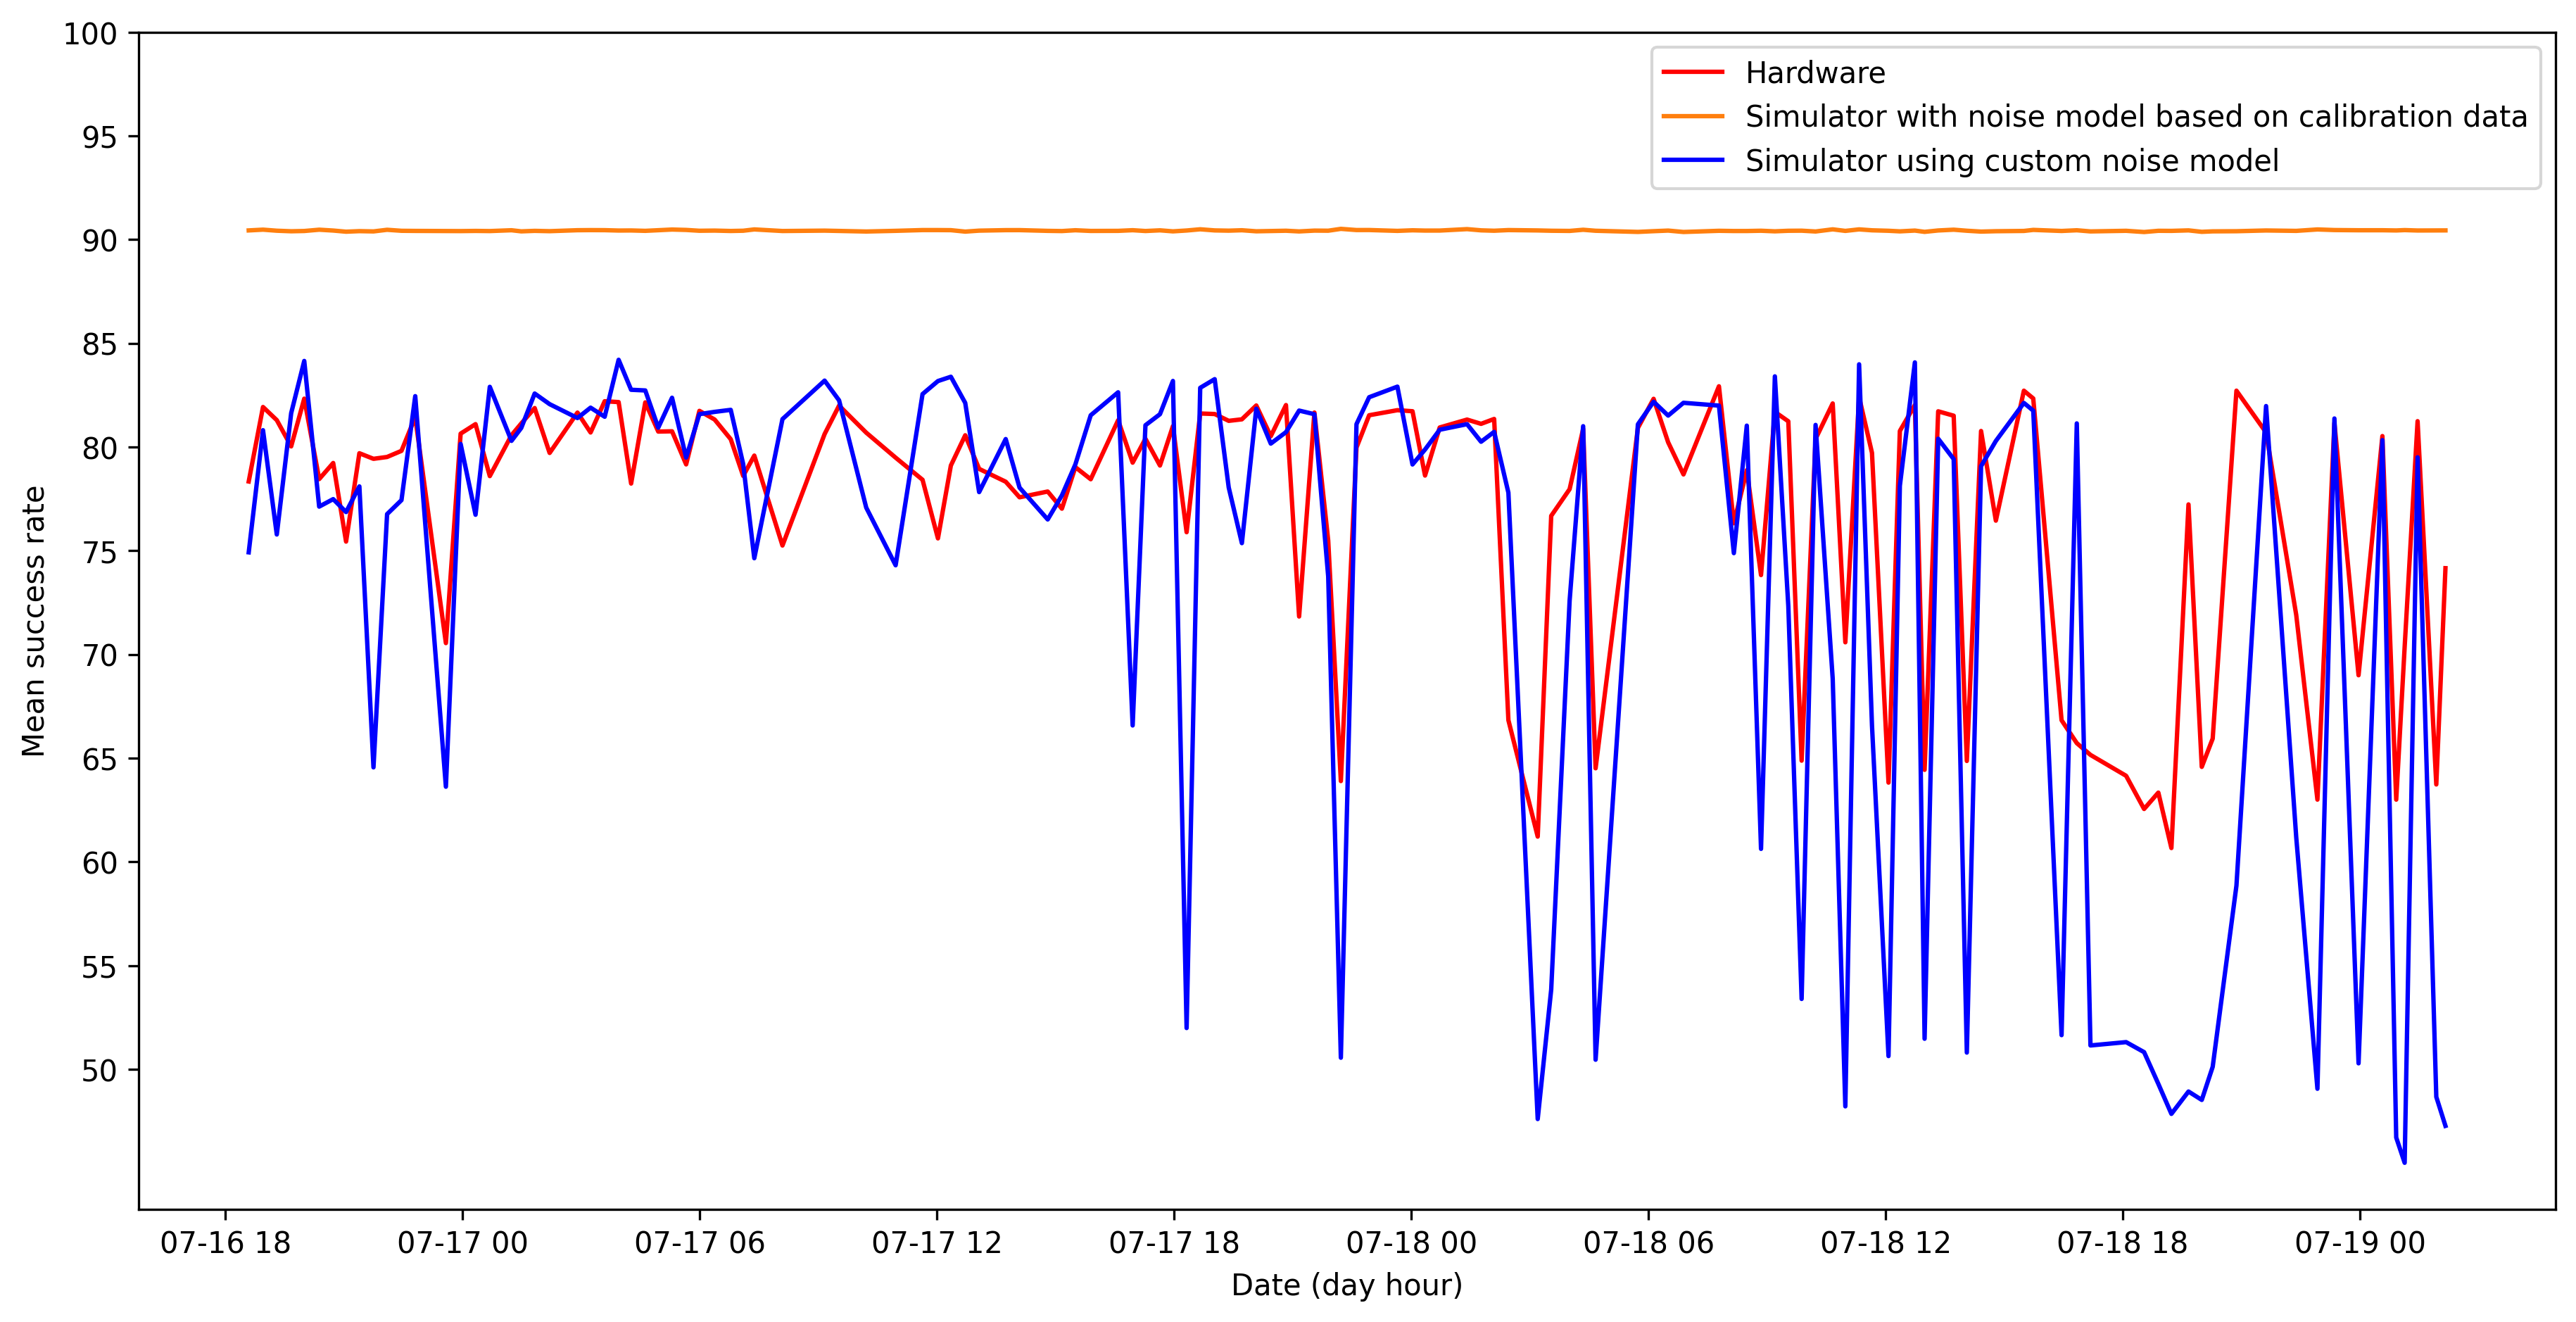

None

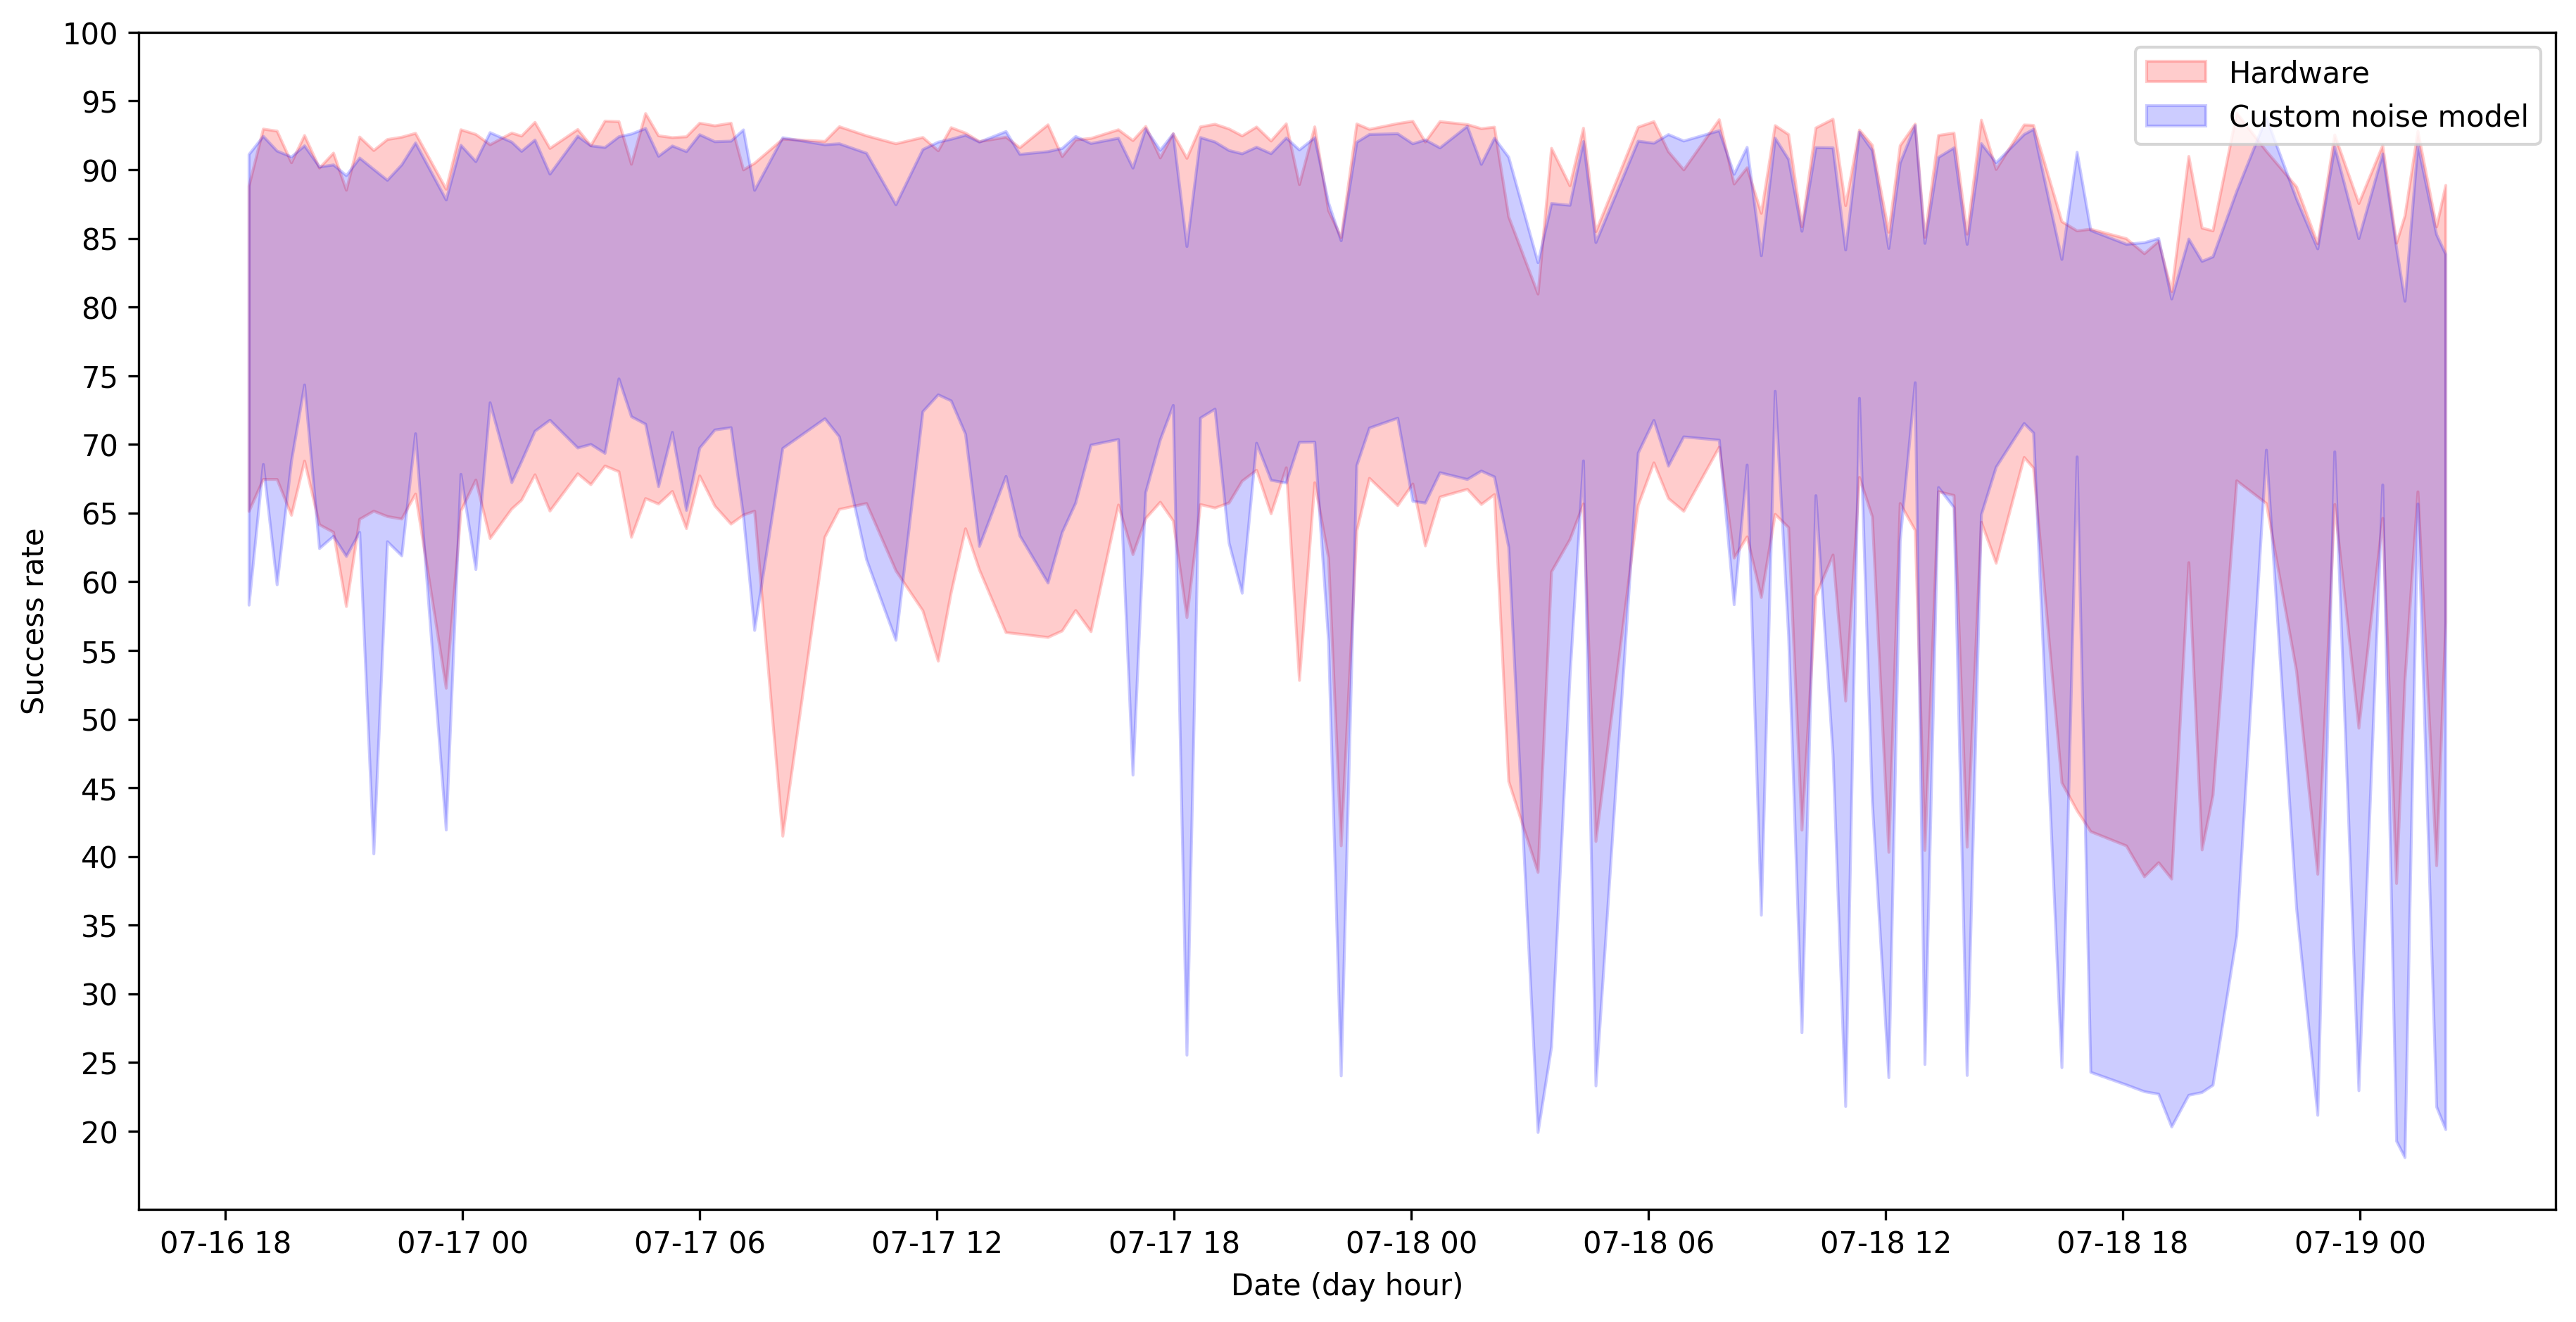

None

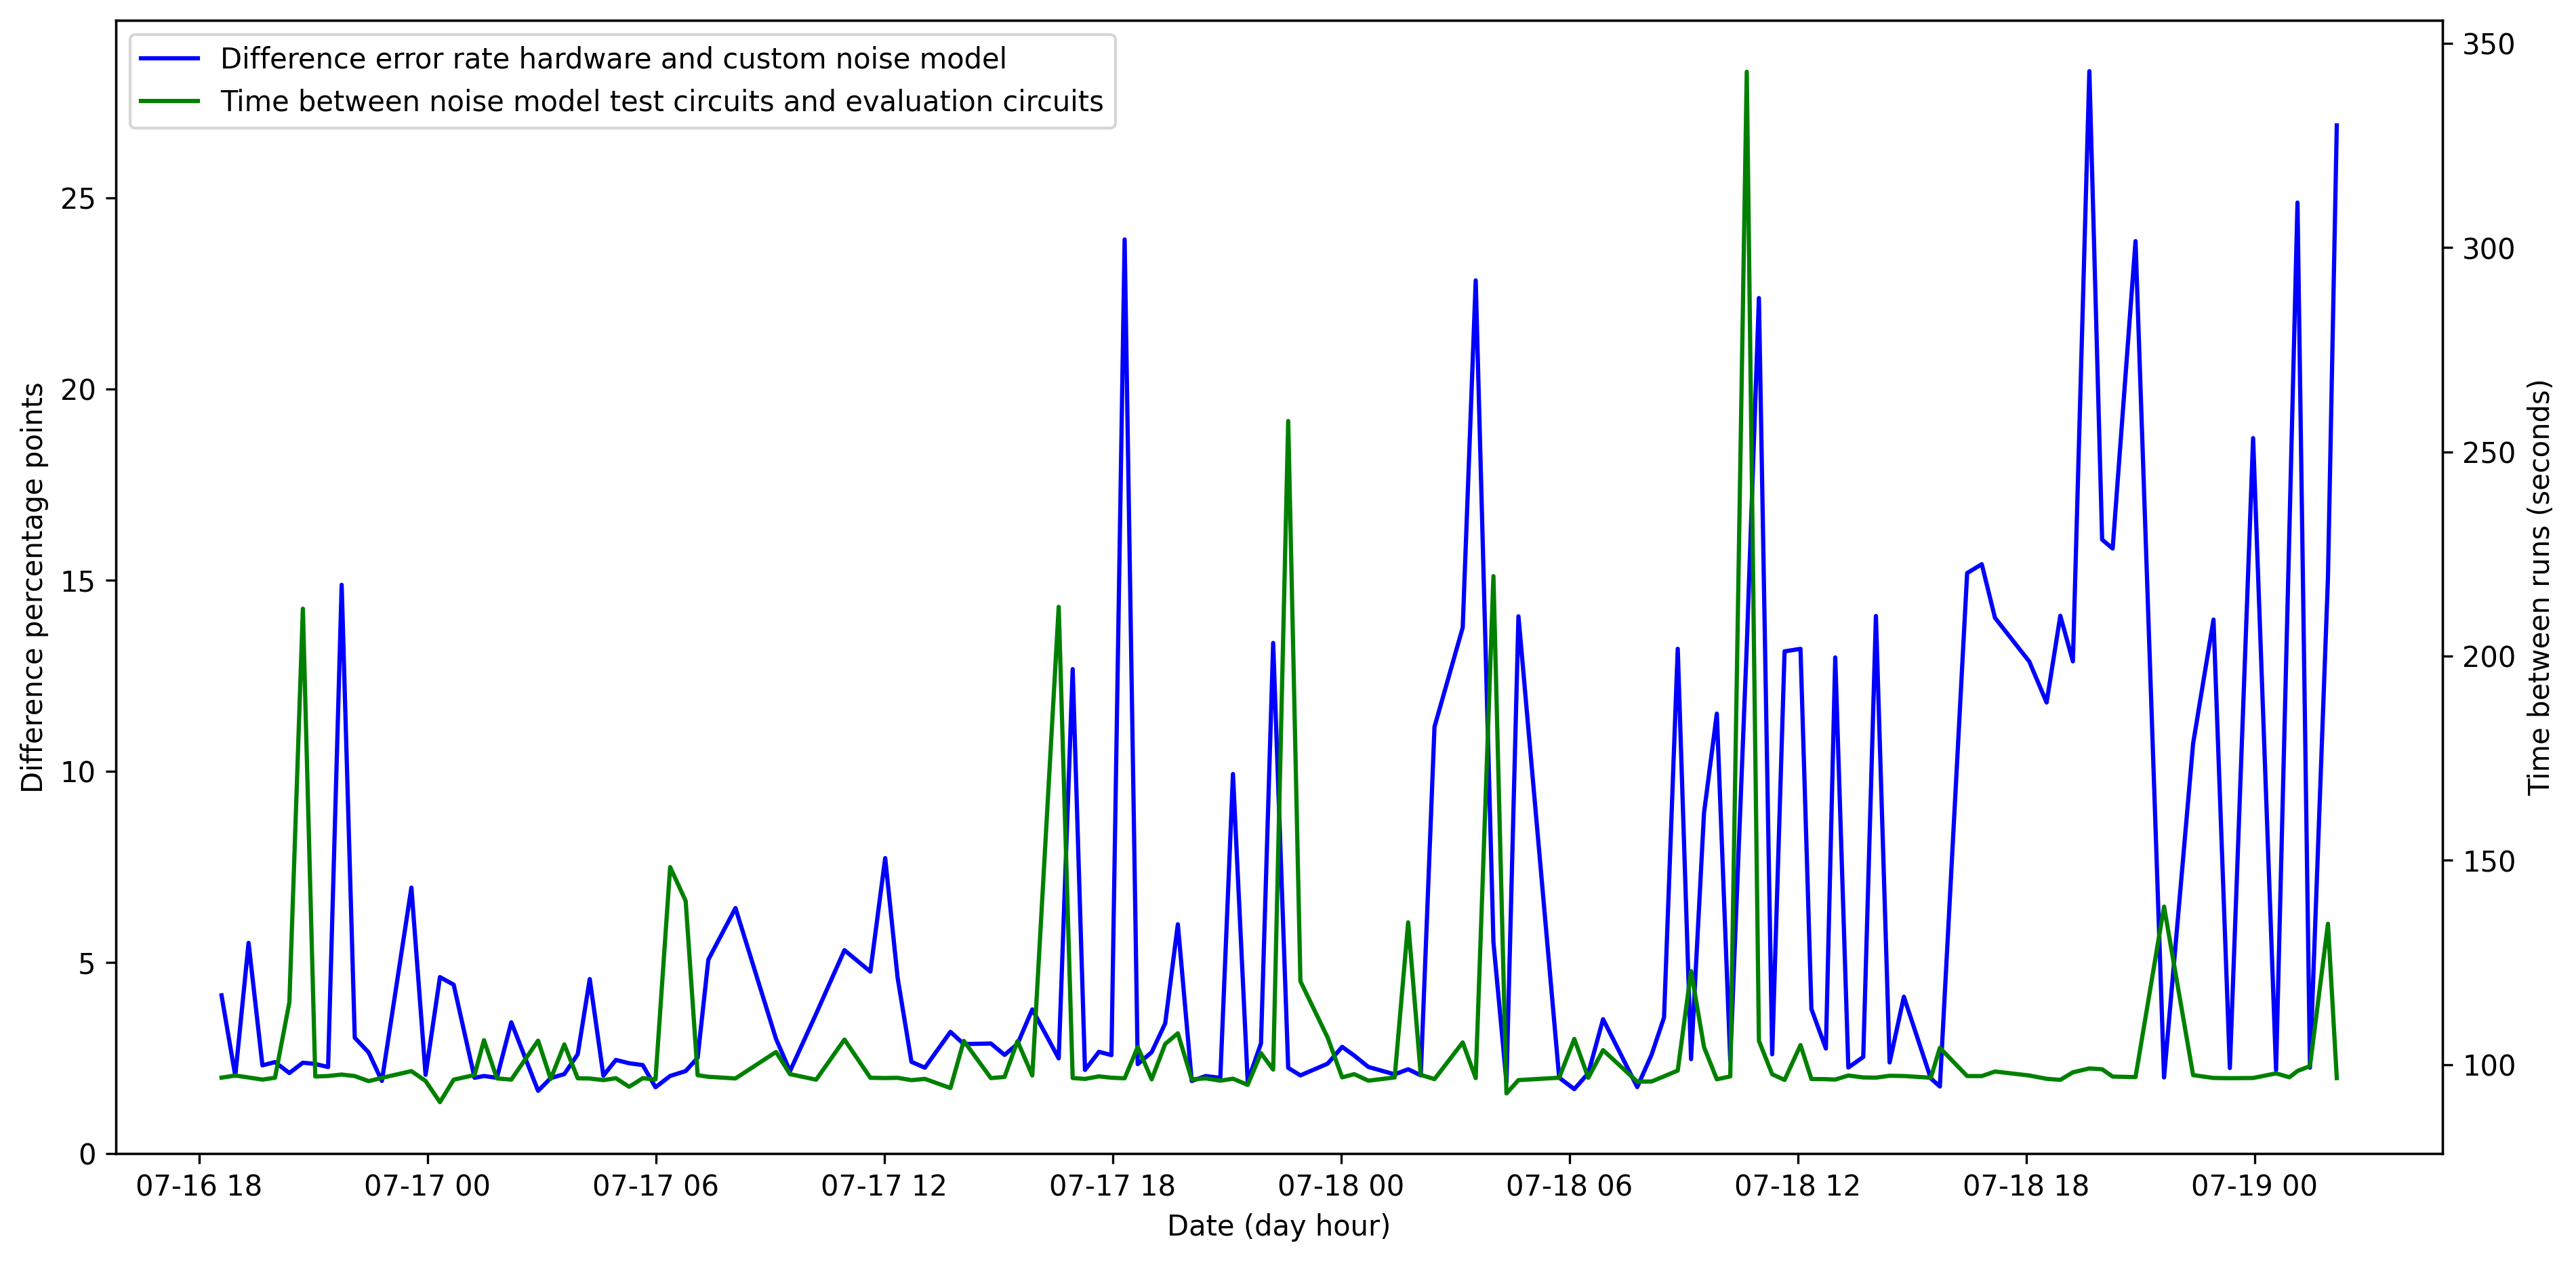

None

time diff min 90.809
time diff max 343.055


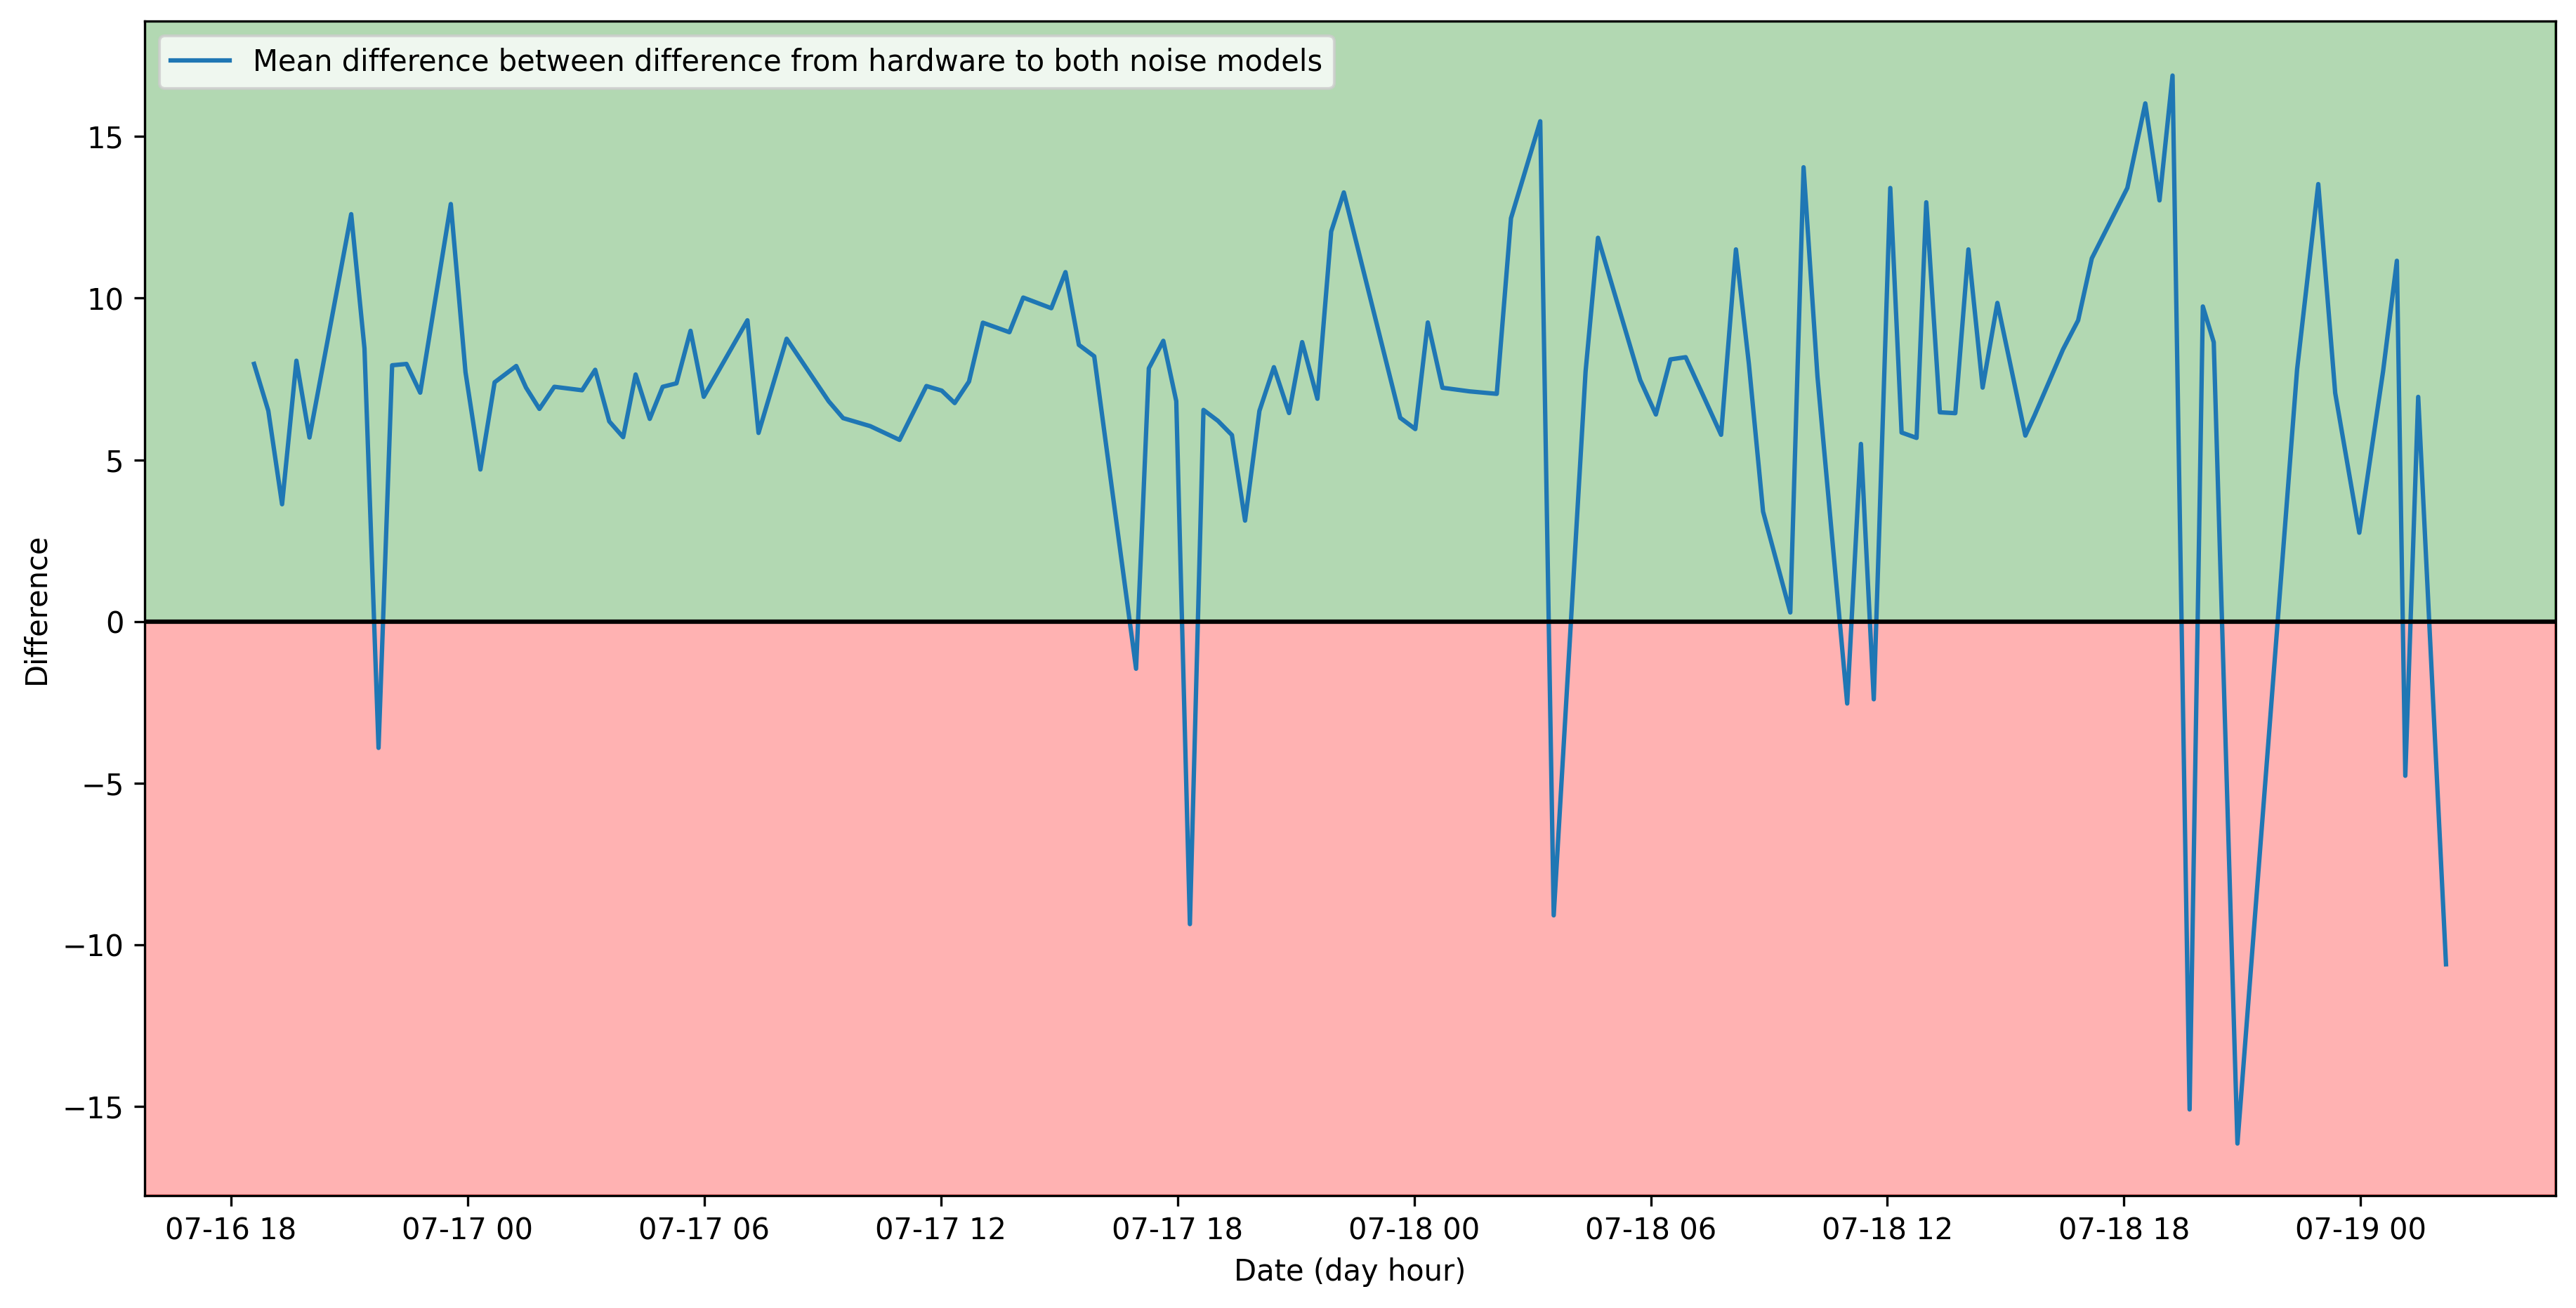

None

total tests = (119,)
worse = (10,)
diff mean 6.8442638655462185
diff after fix
6.881174775792674
7.288810651790121


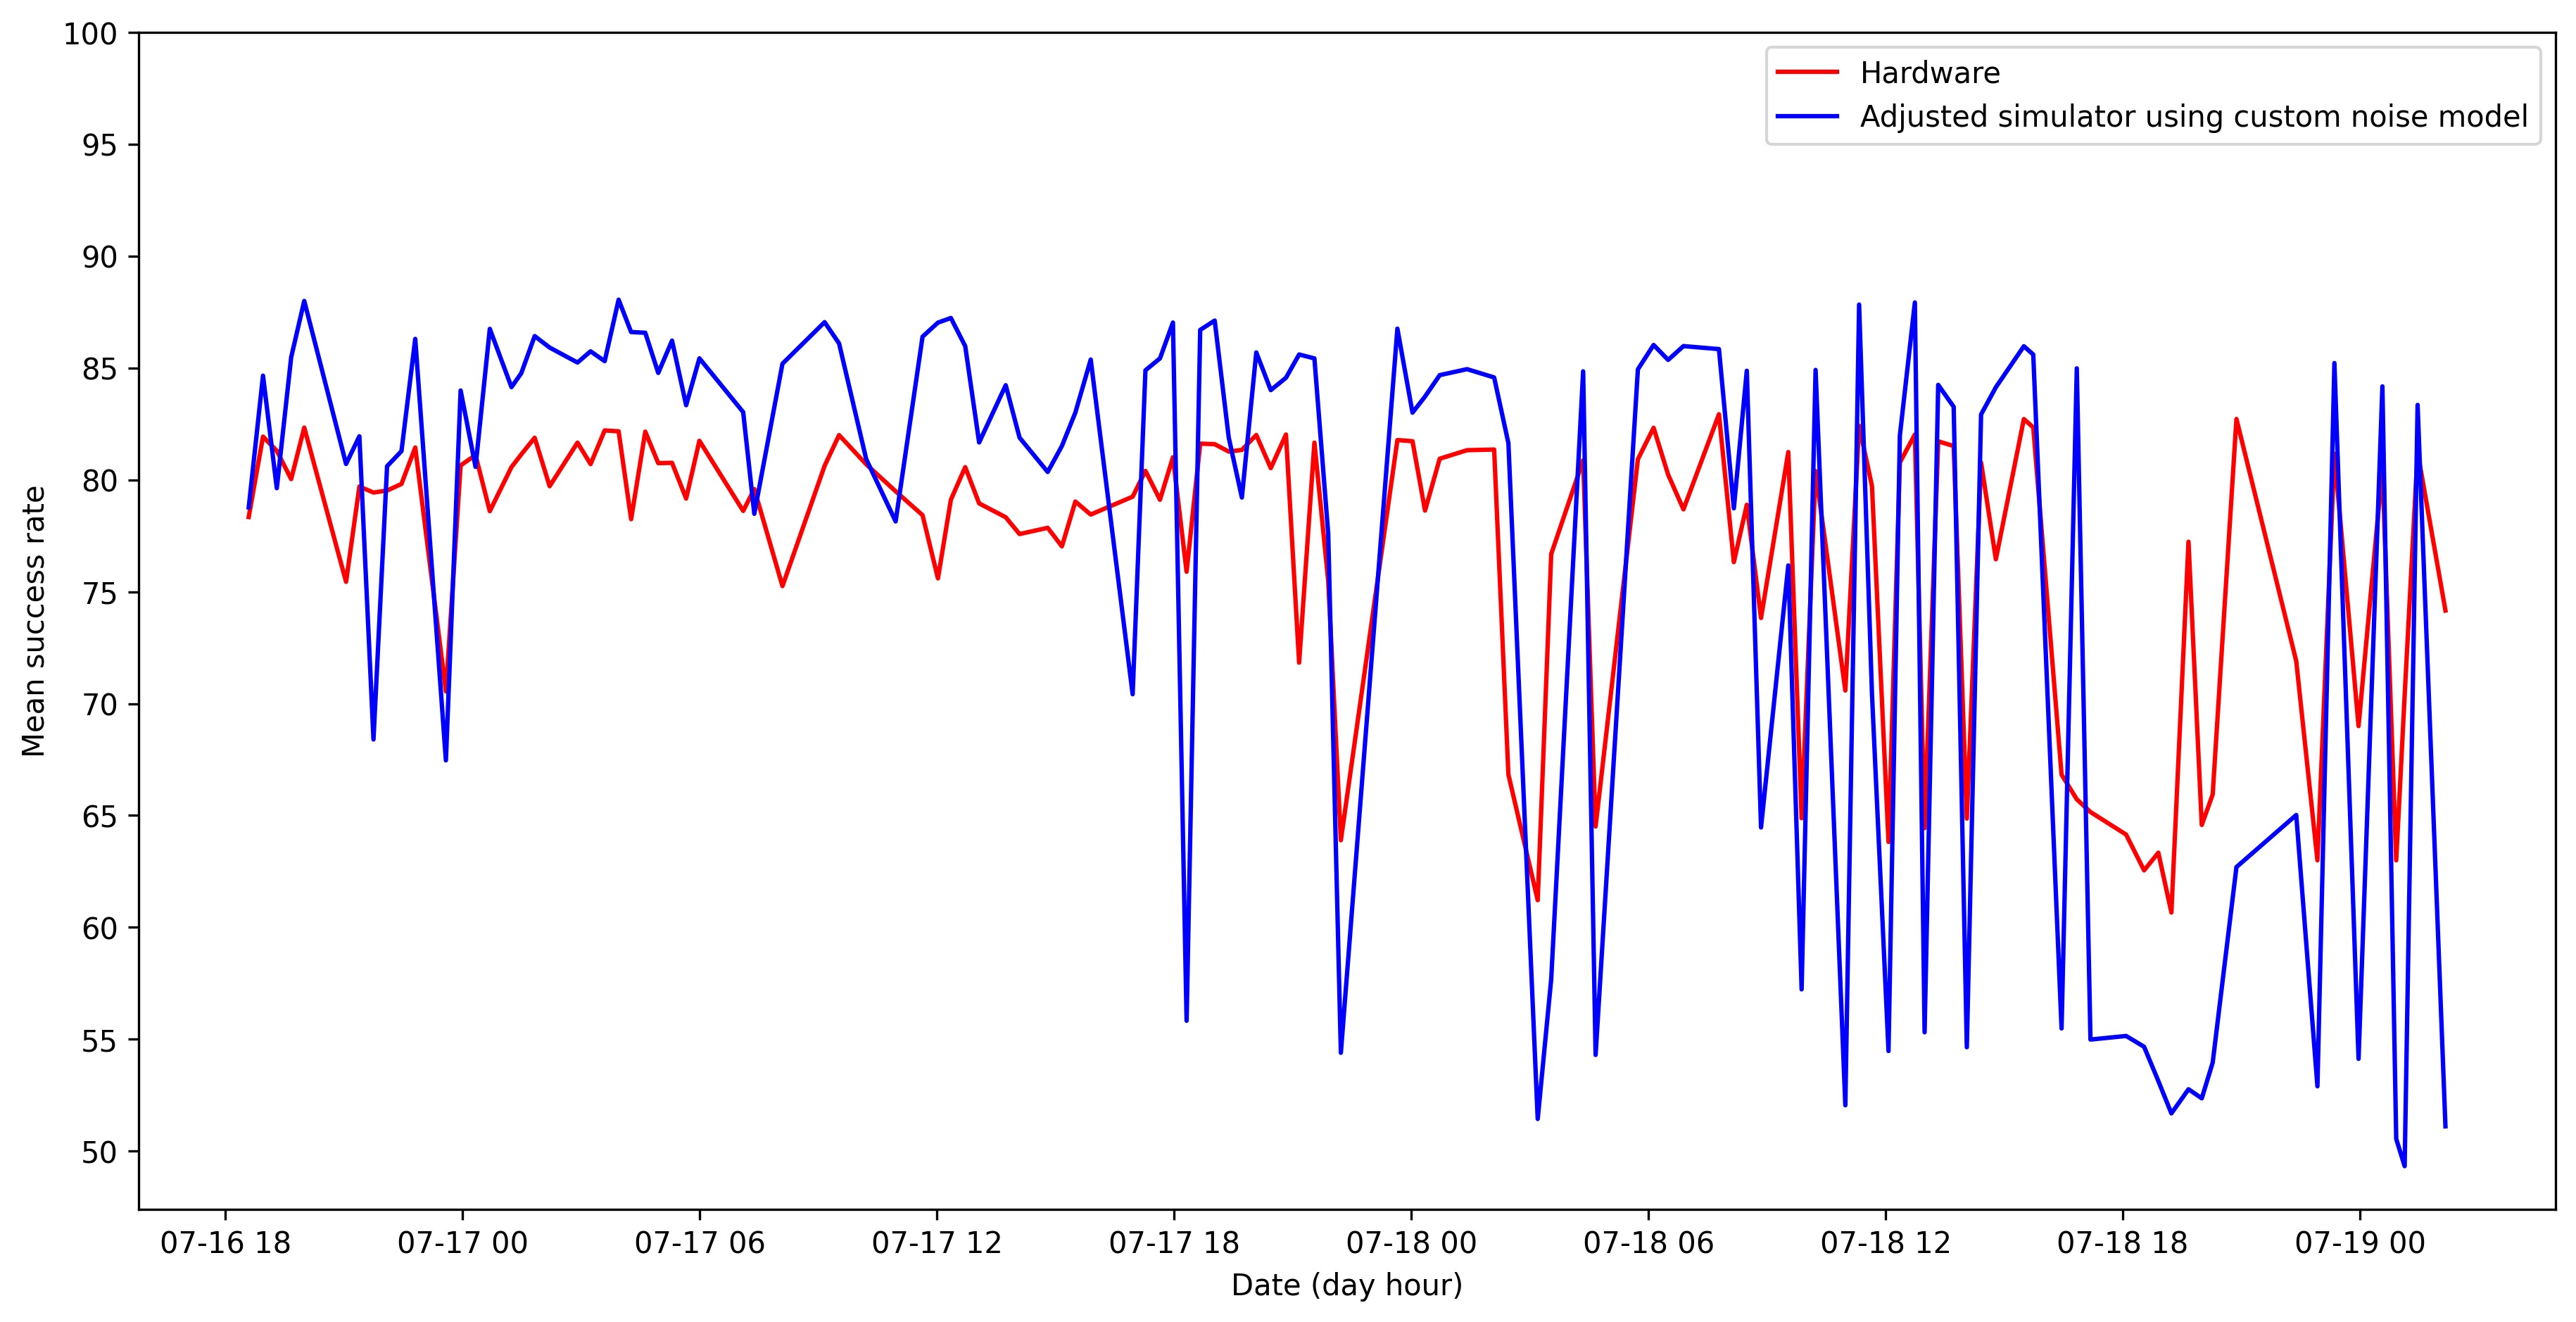

None

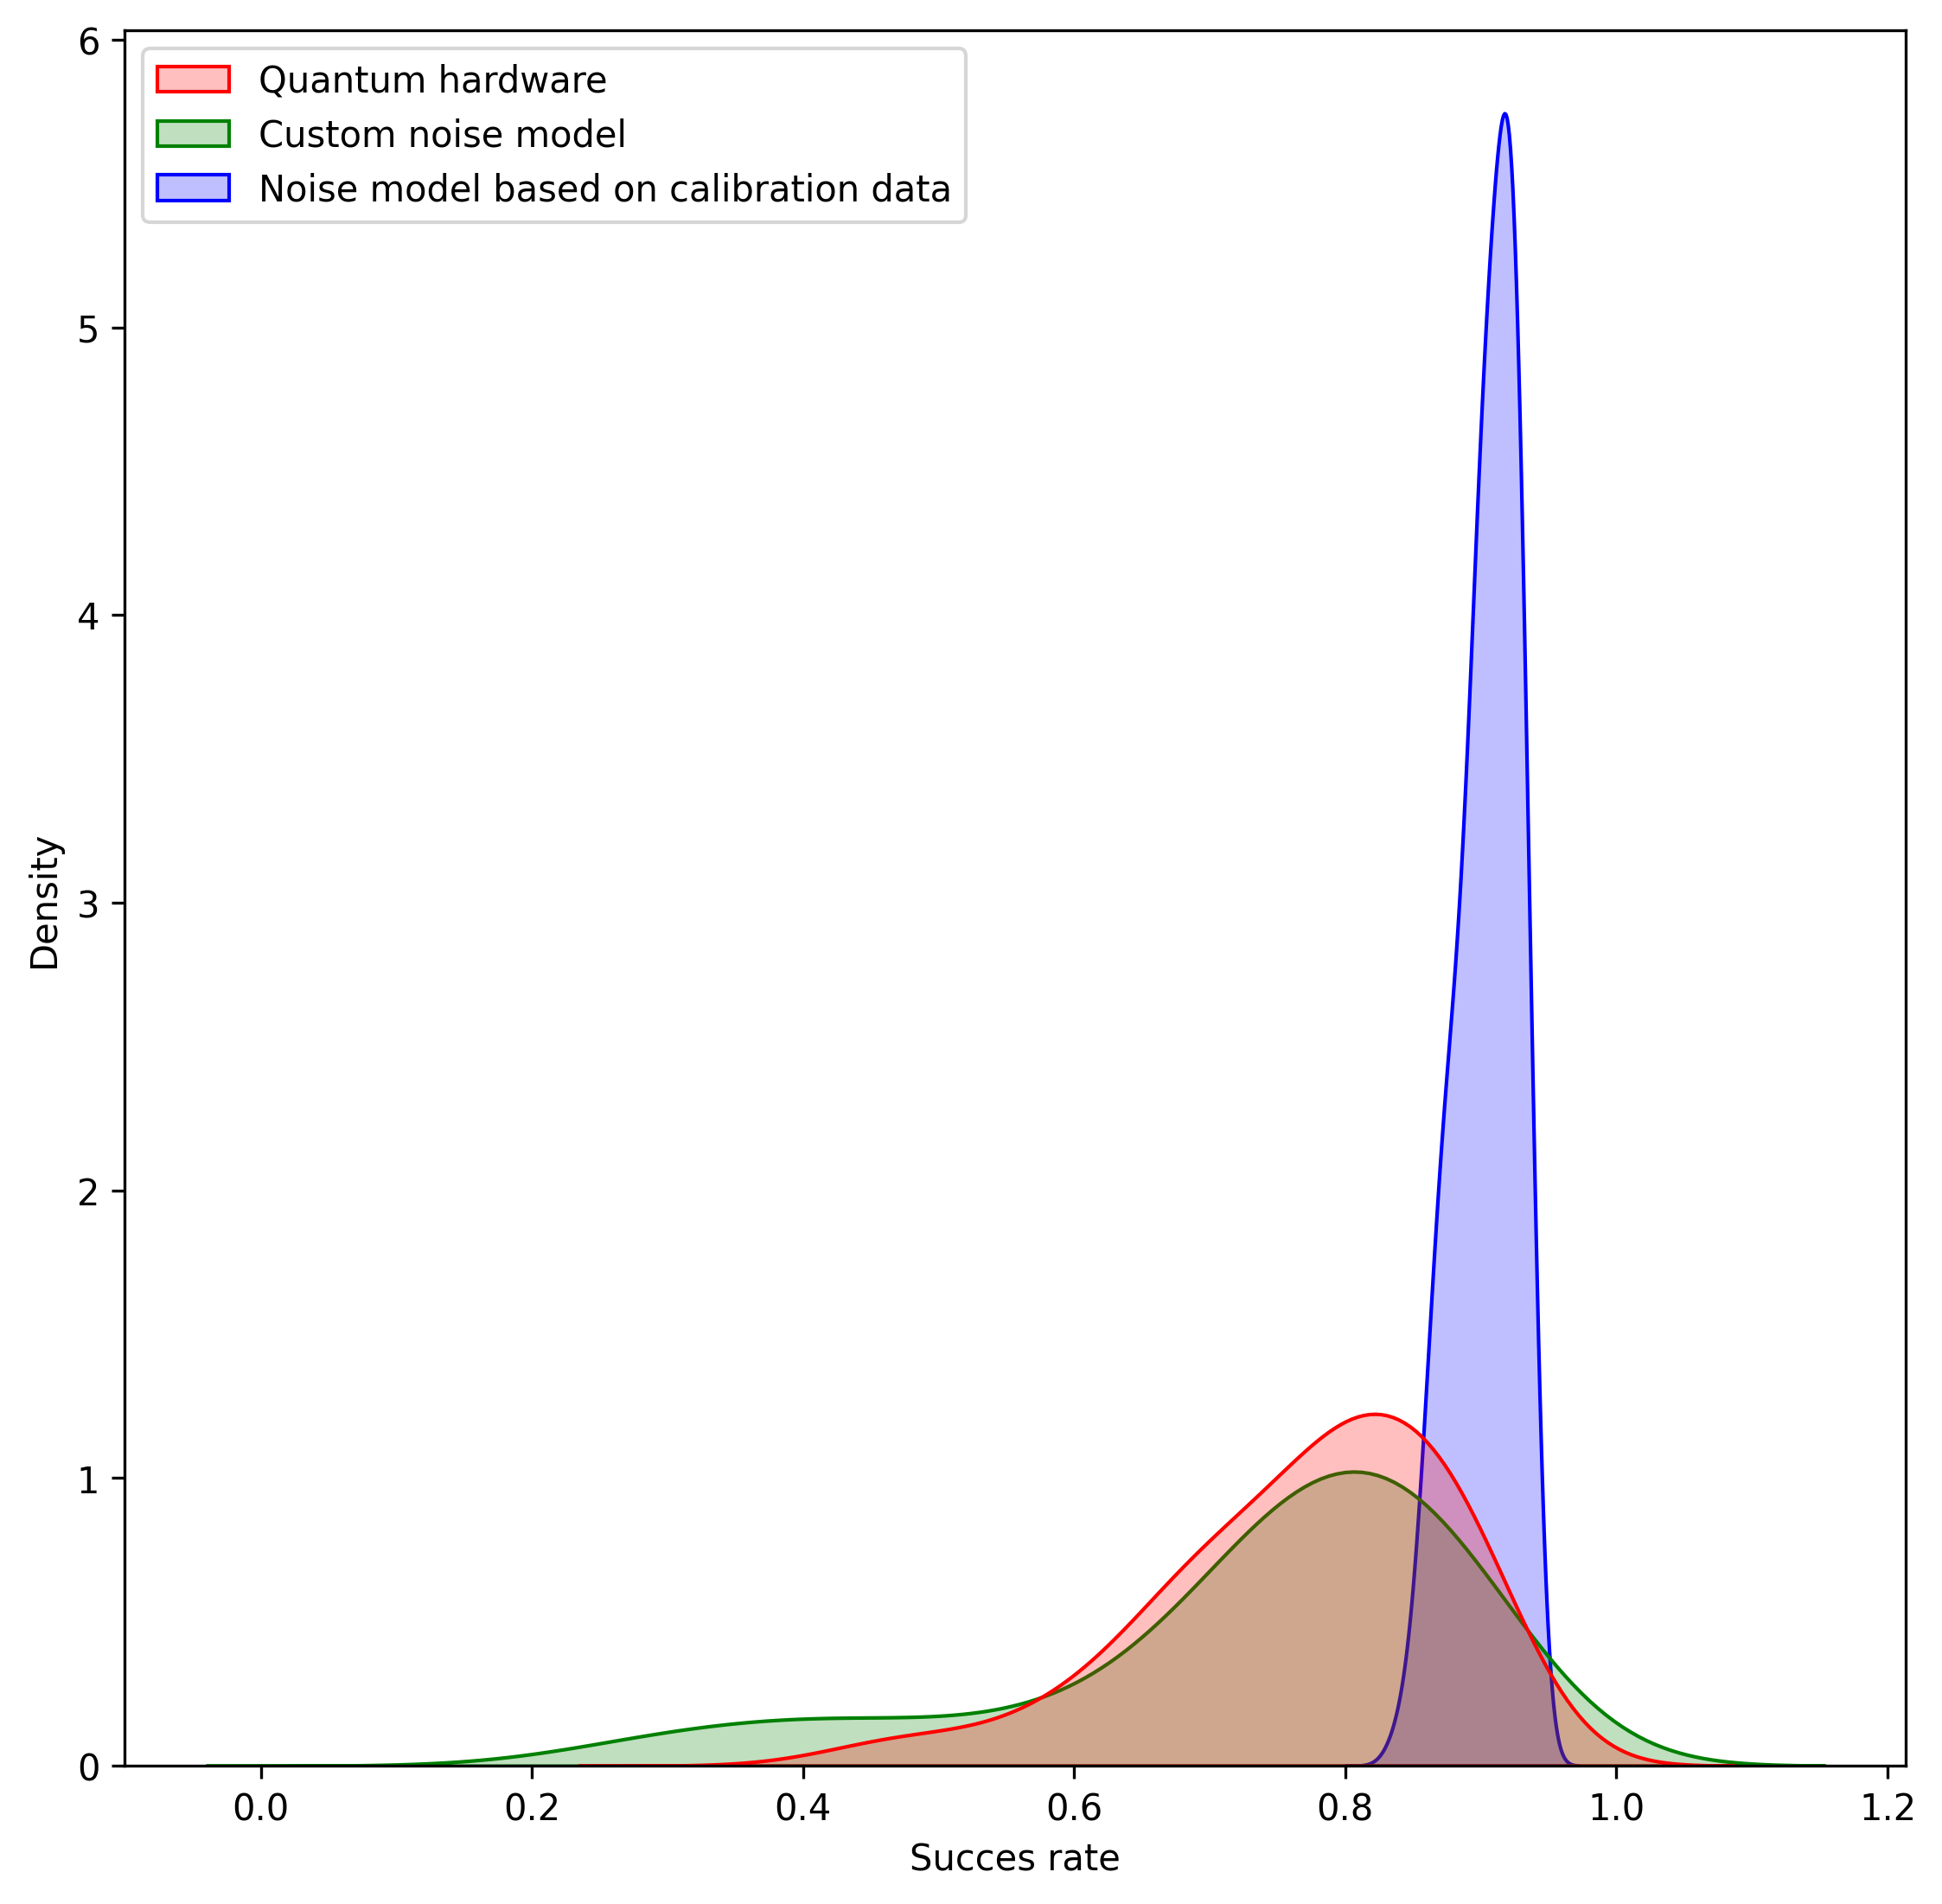

None

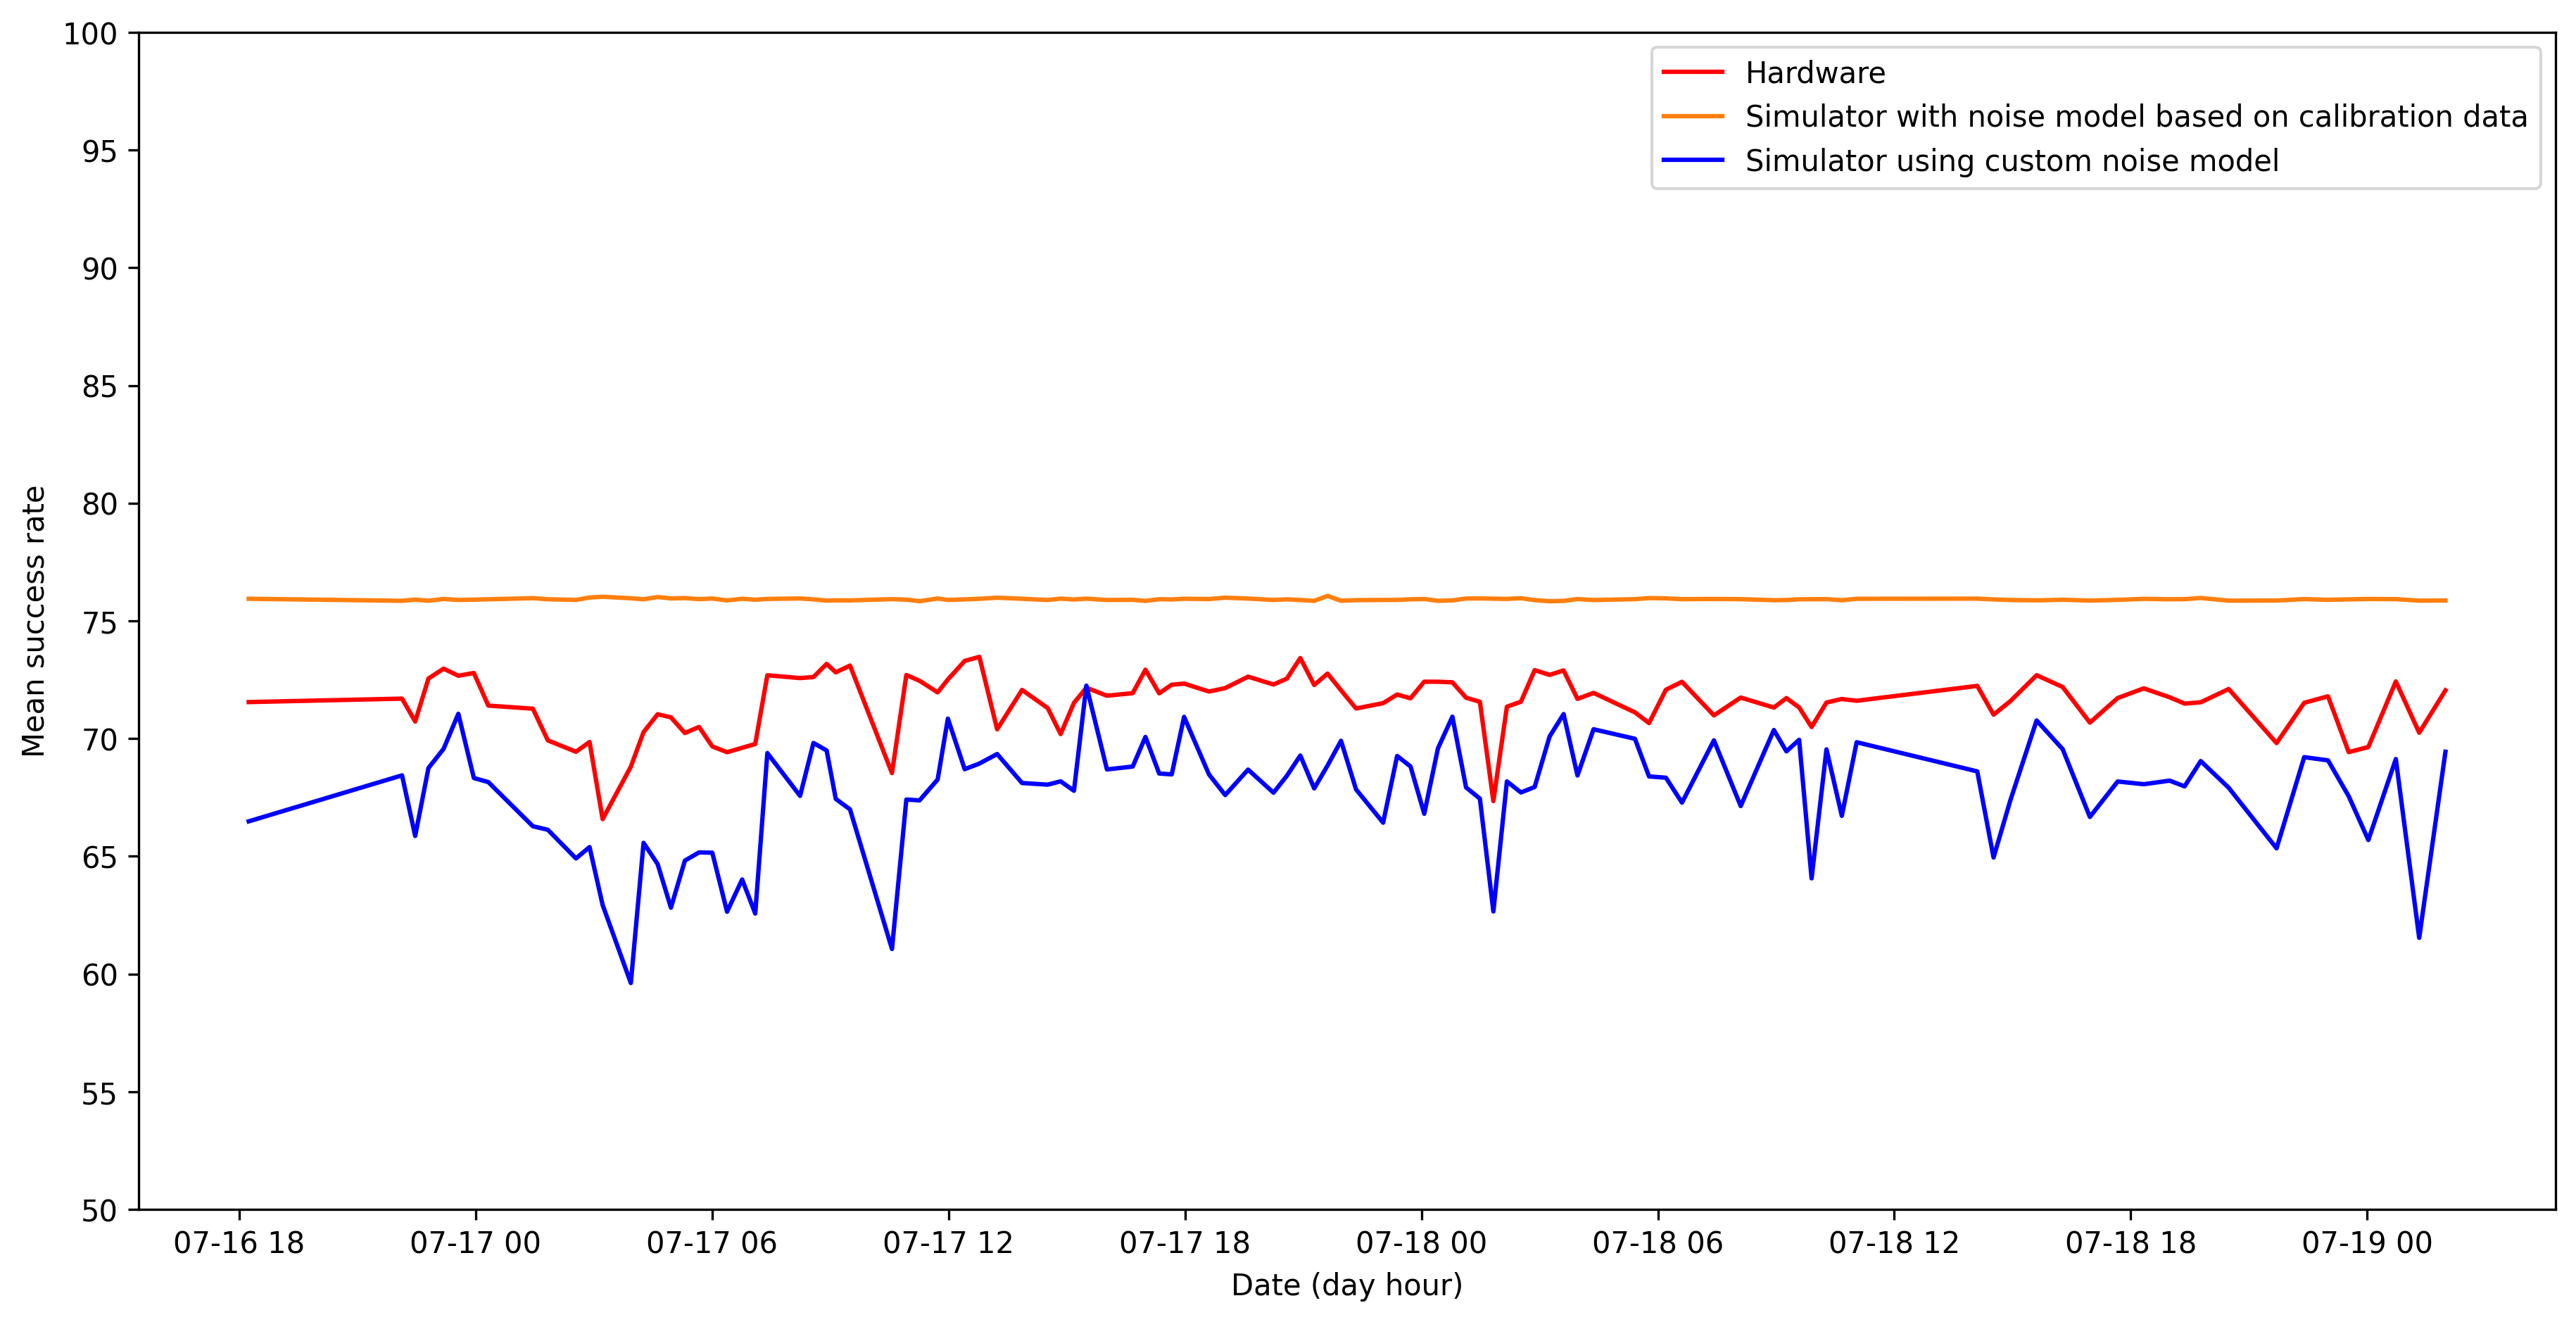

None

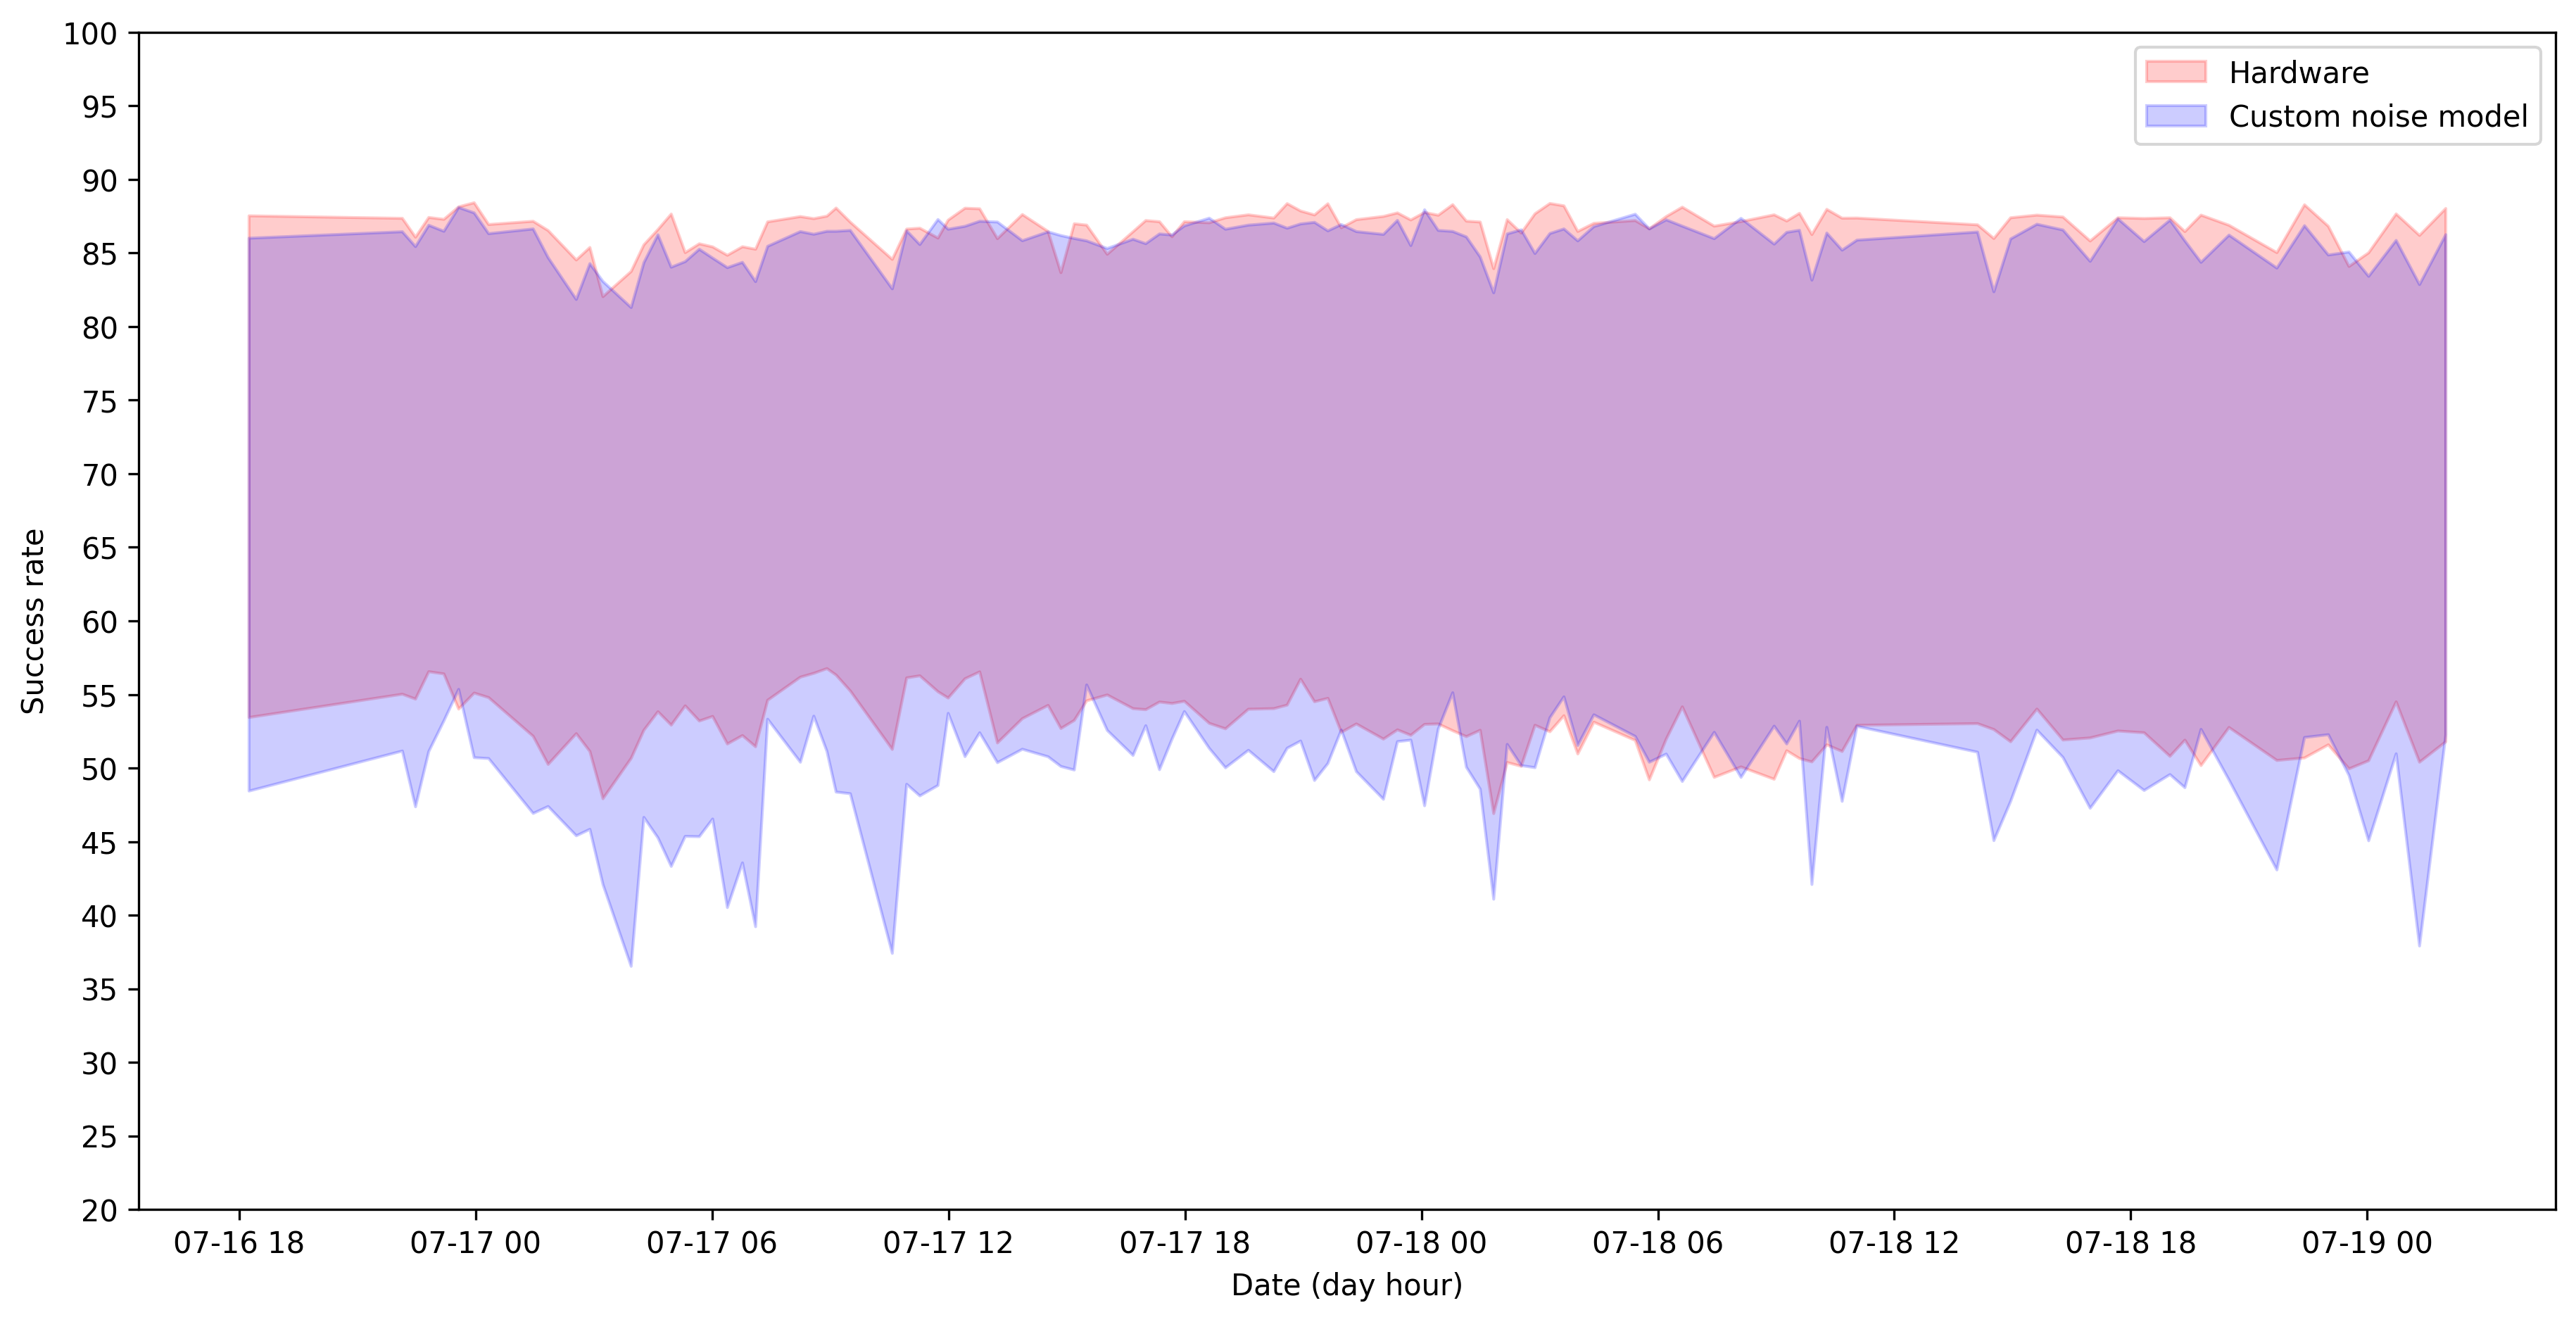

None

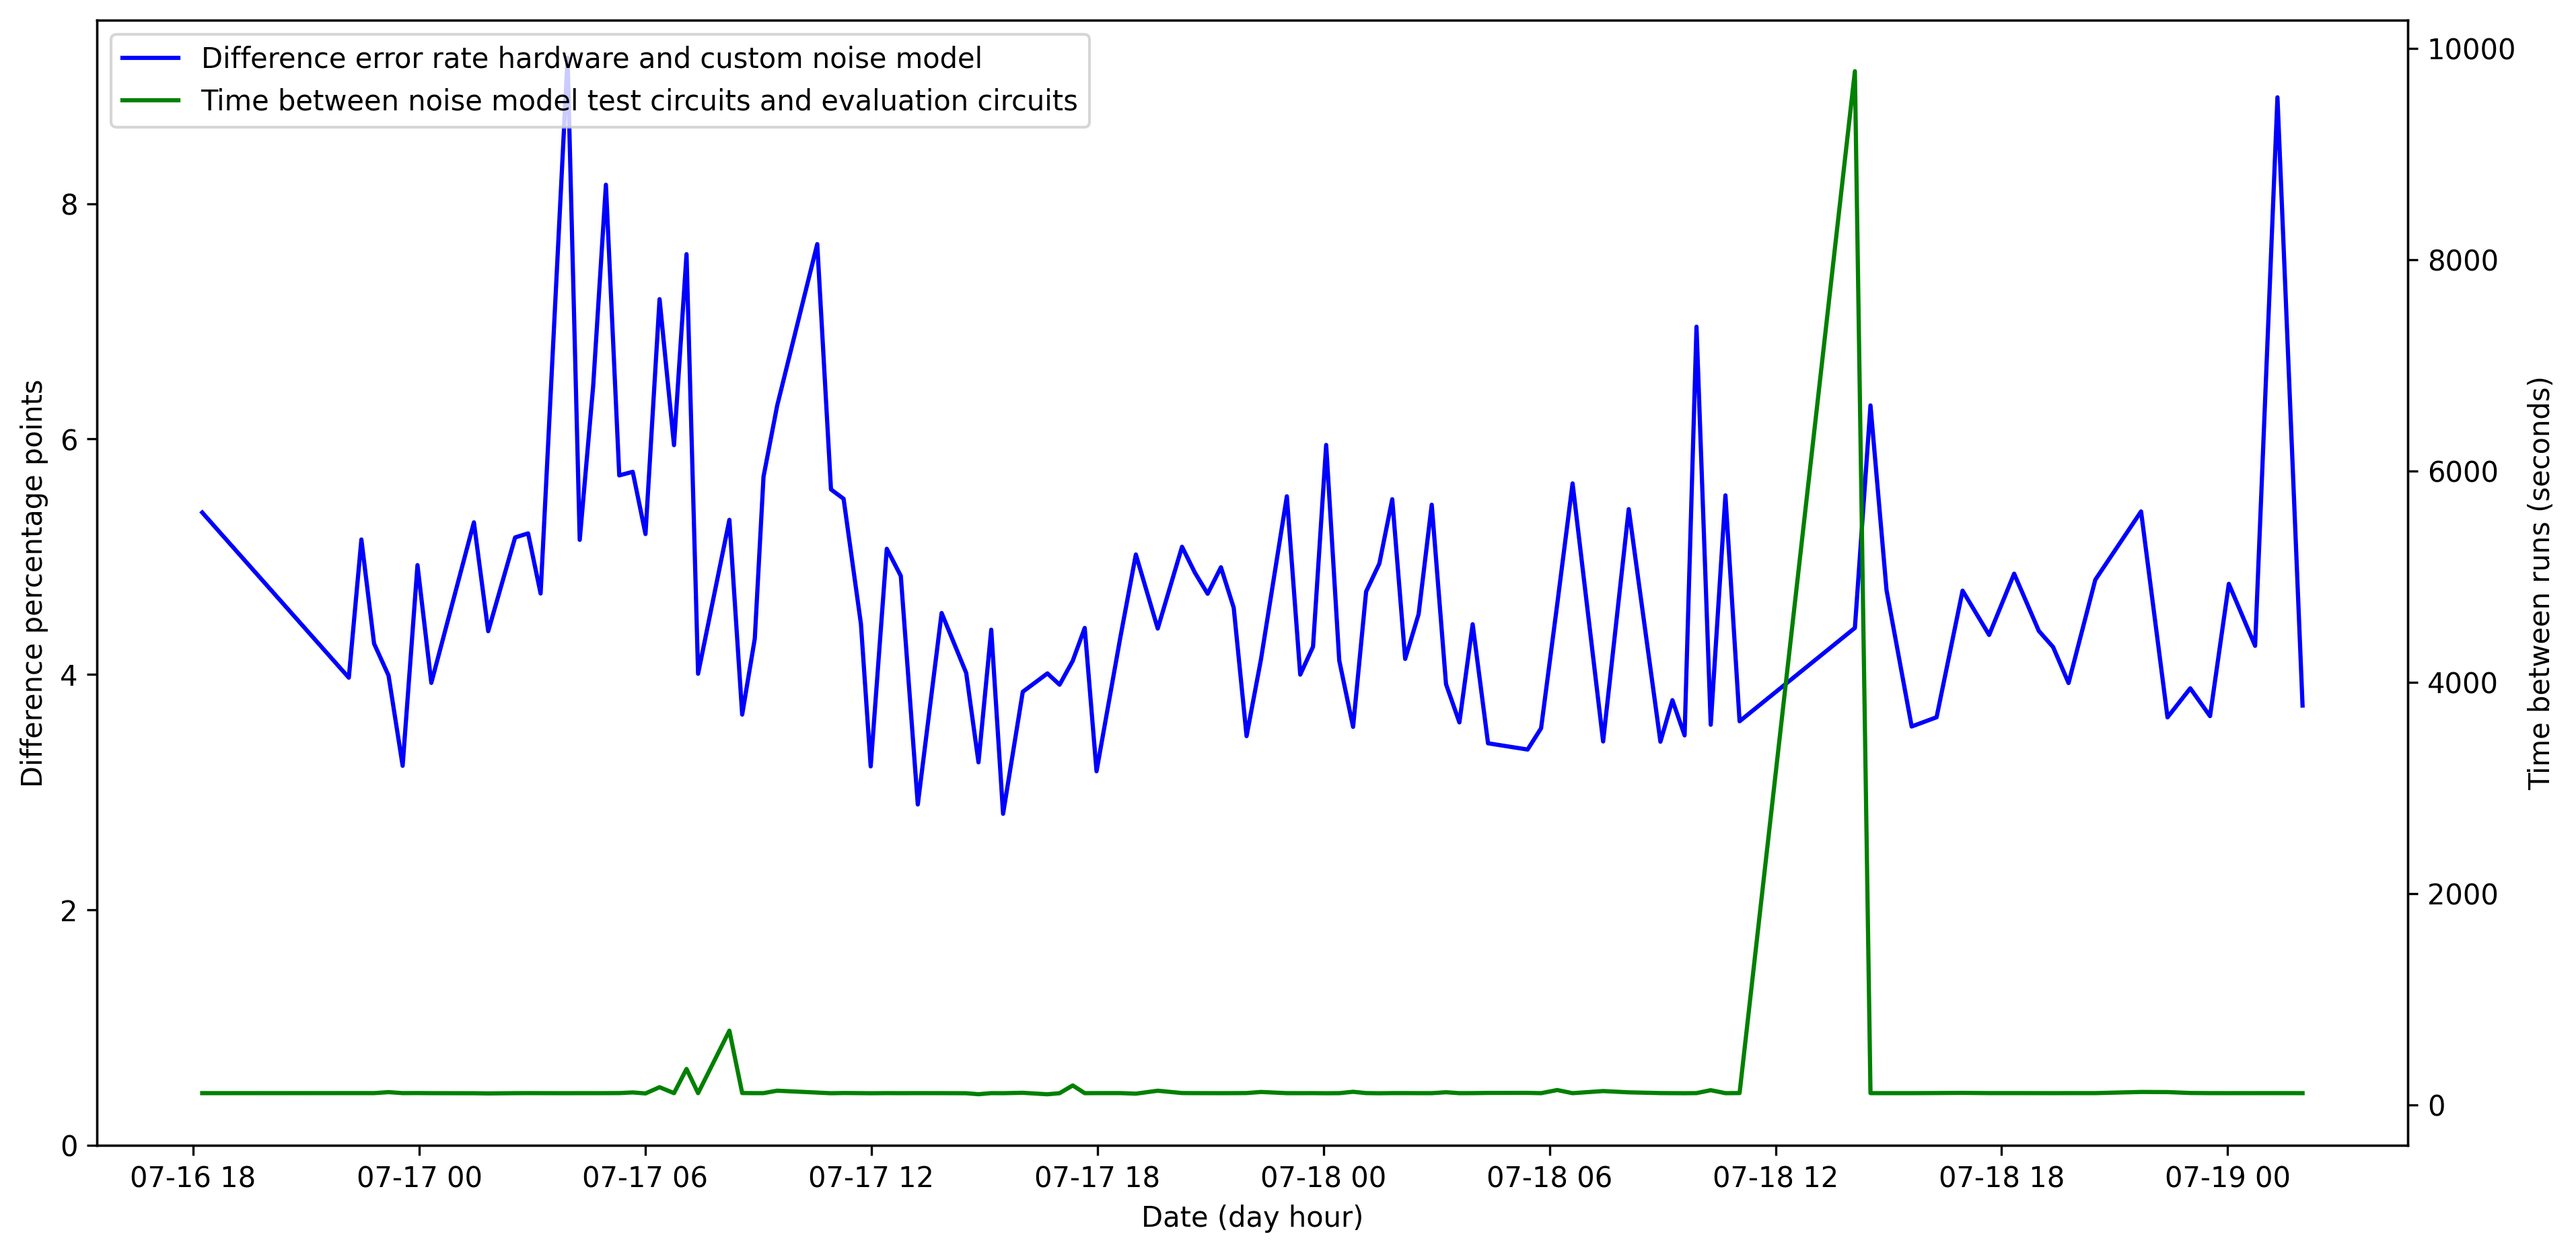

None

time diff min 103.067
time diff max 9785.11


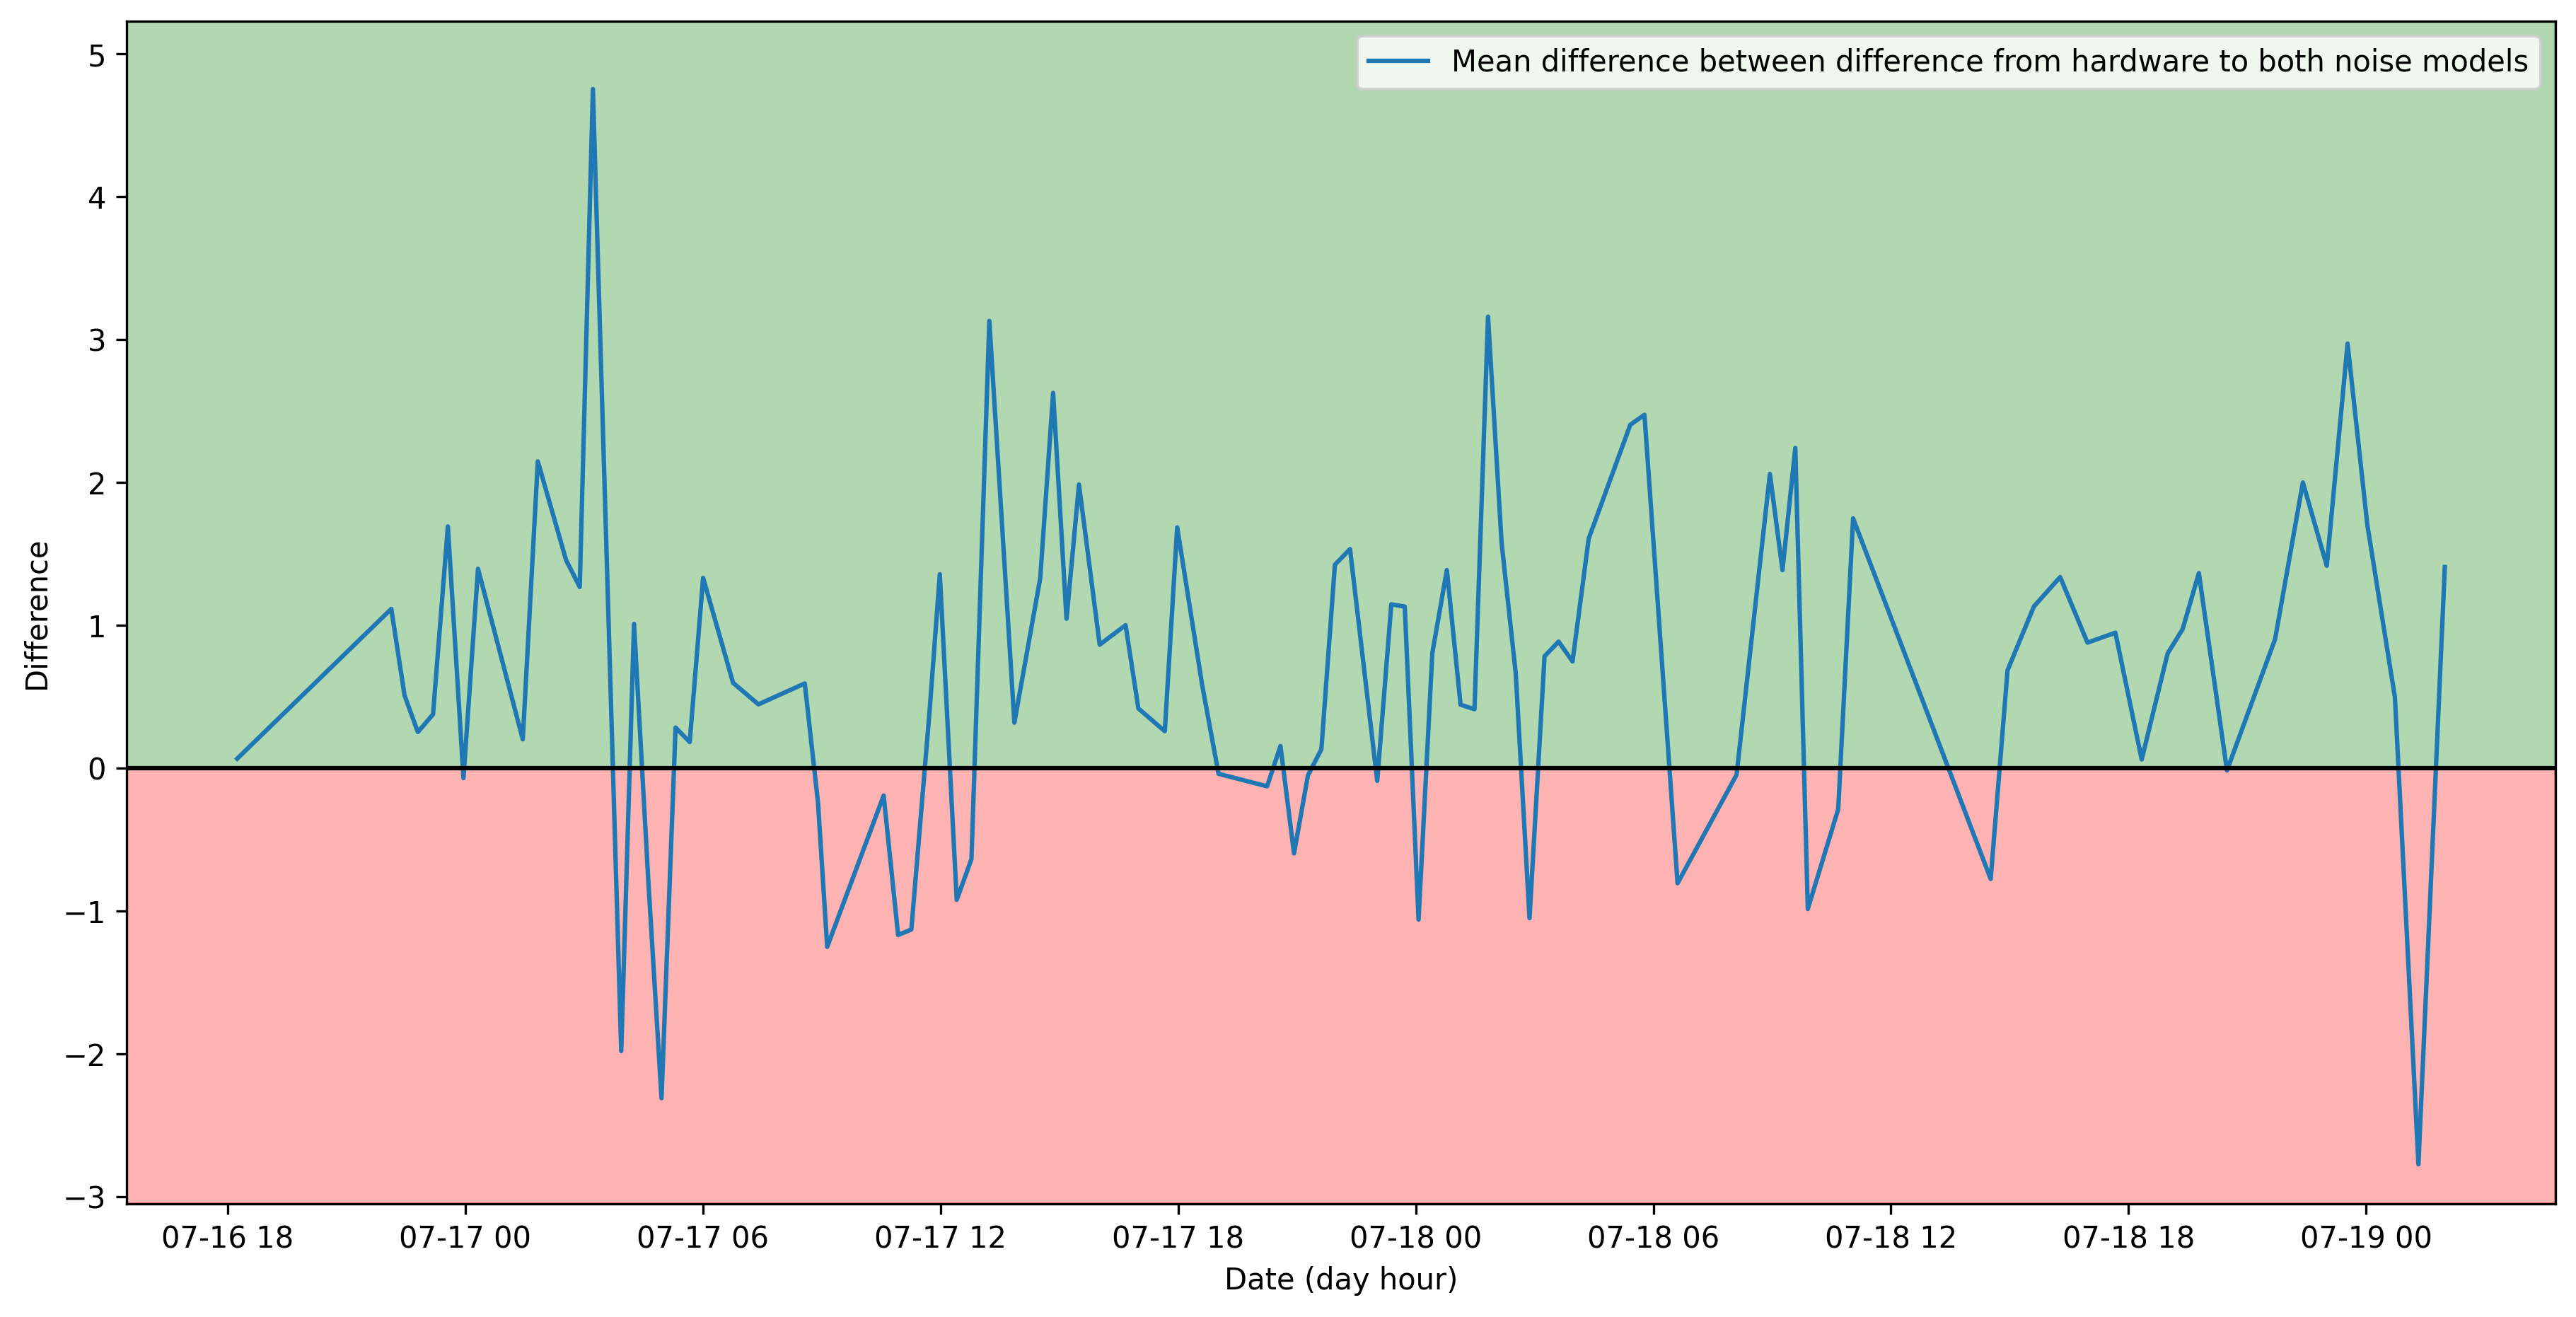

None

total tests = (97,)
worse = (25,)
diff mean 0.6878123711340207
diff after fix
3.3919288119885214
4.164437278137953


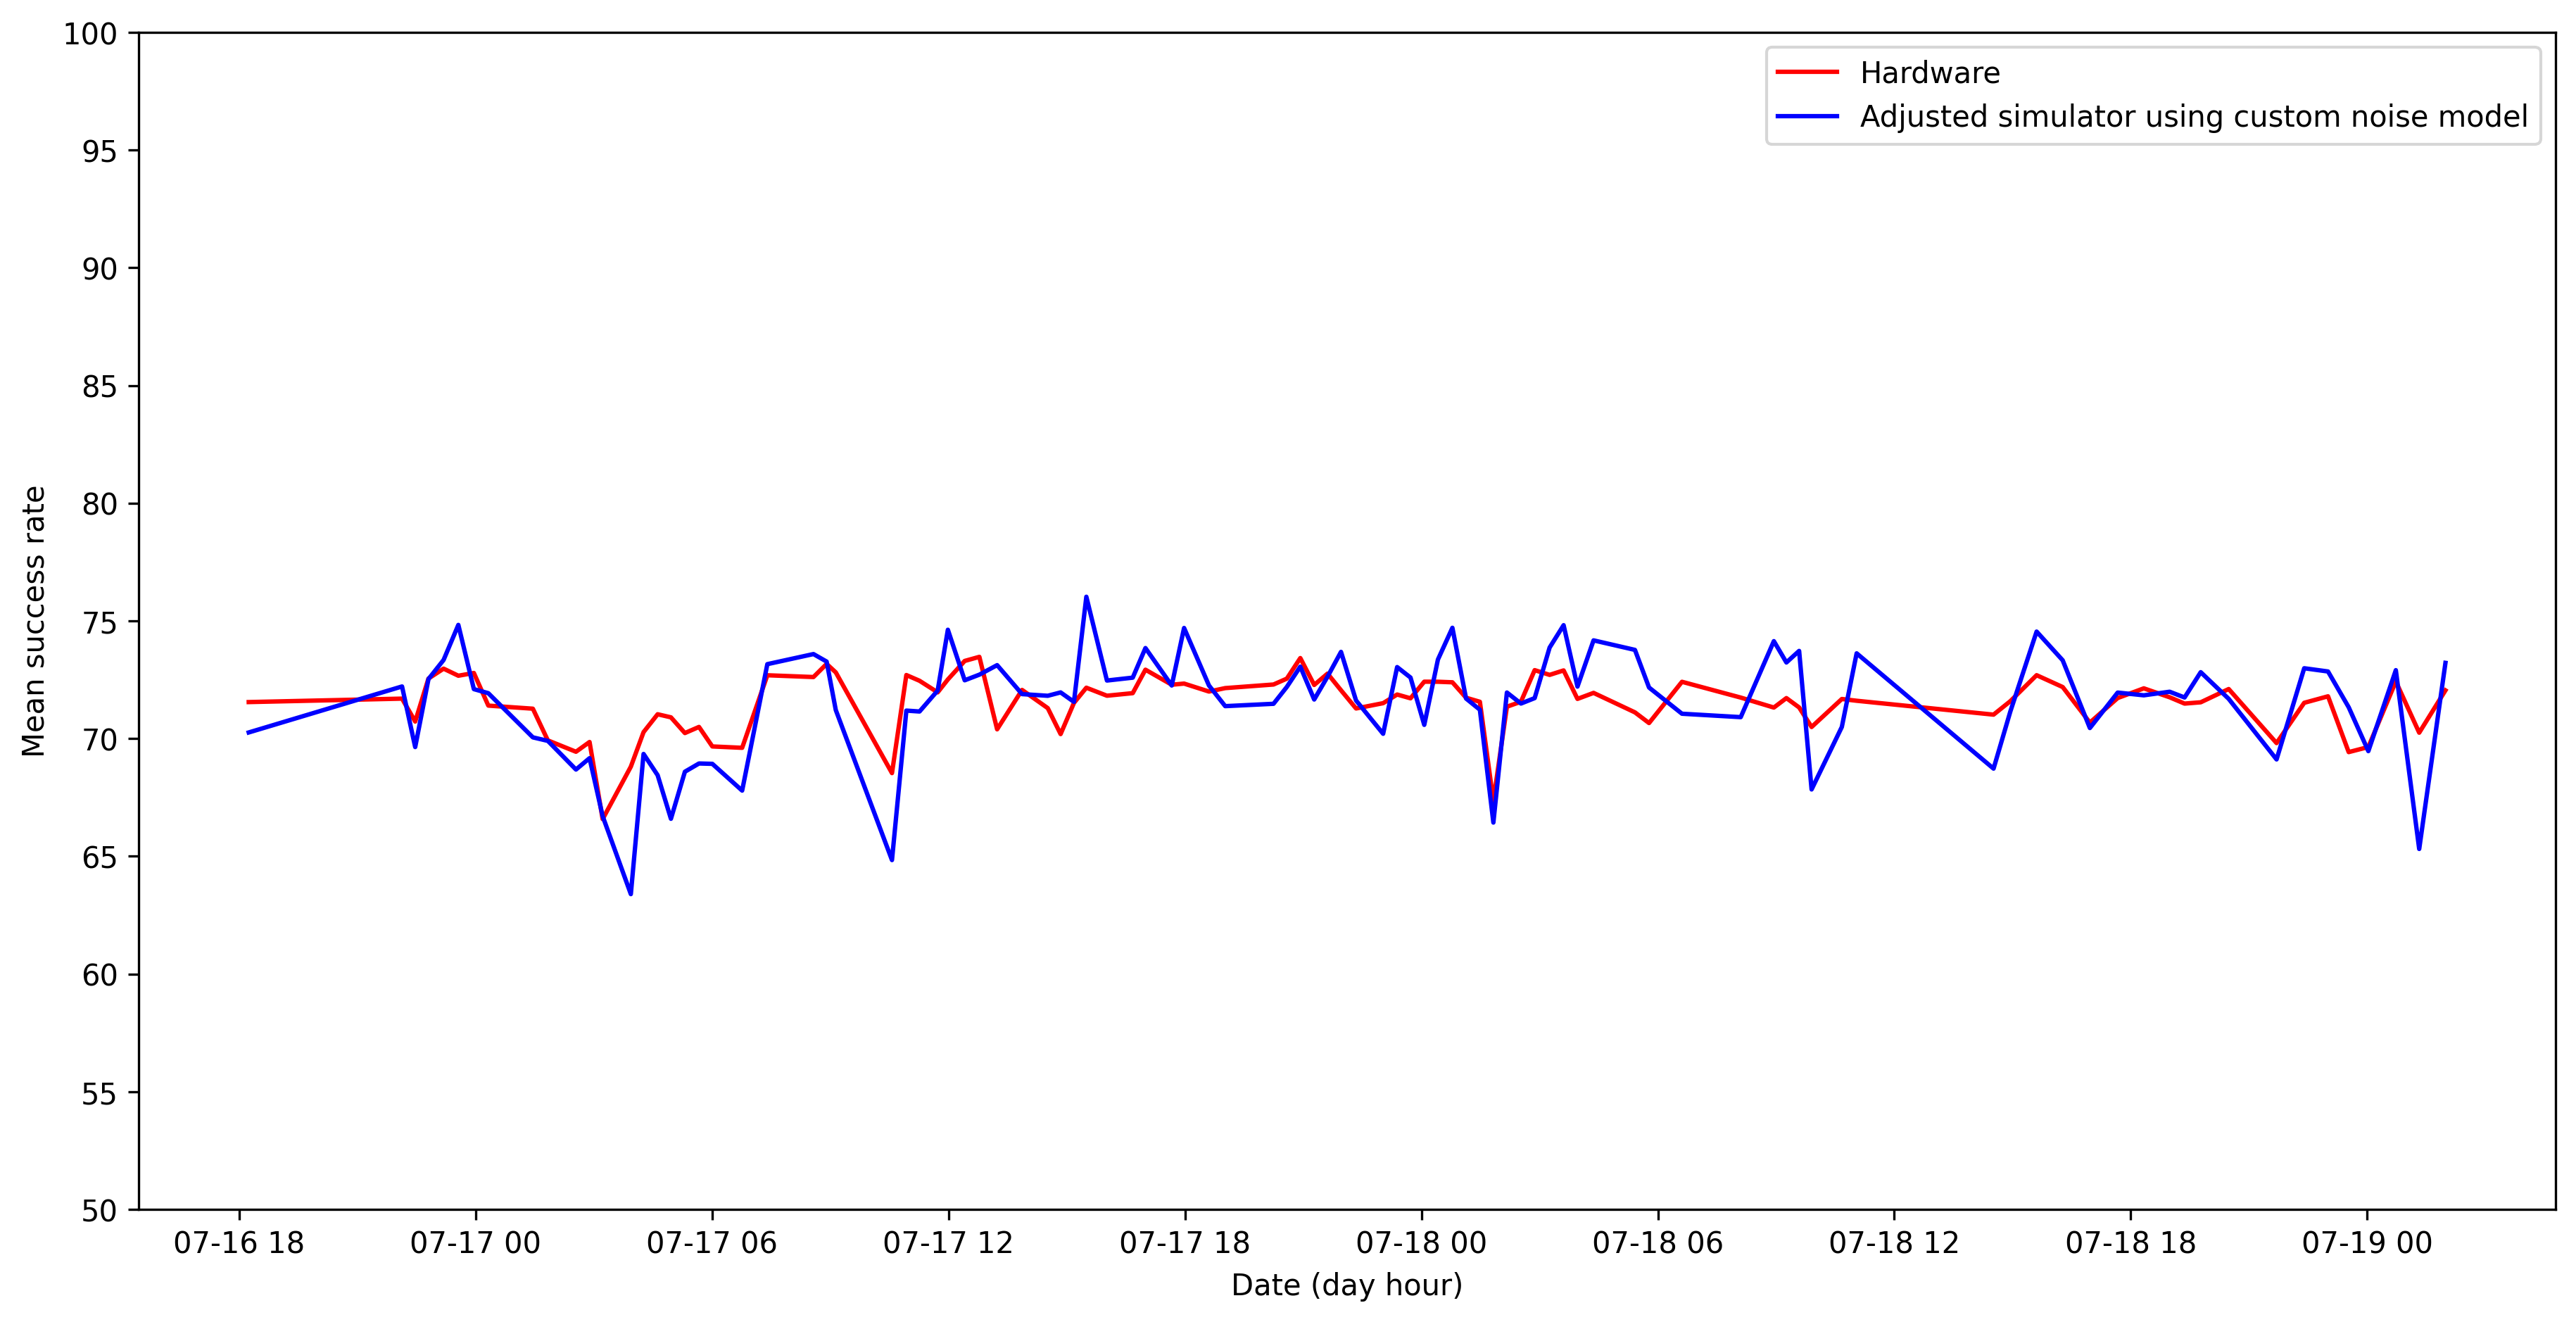

None

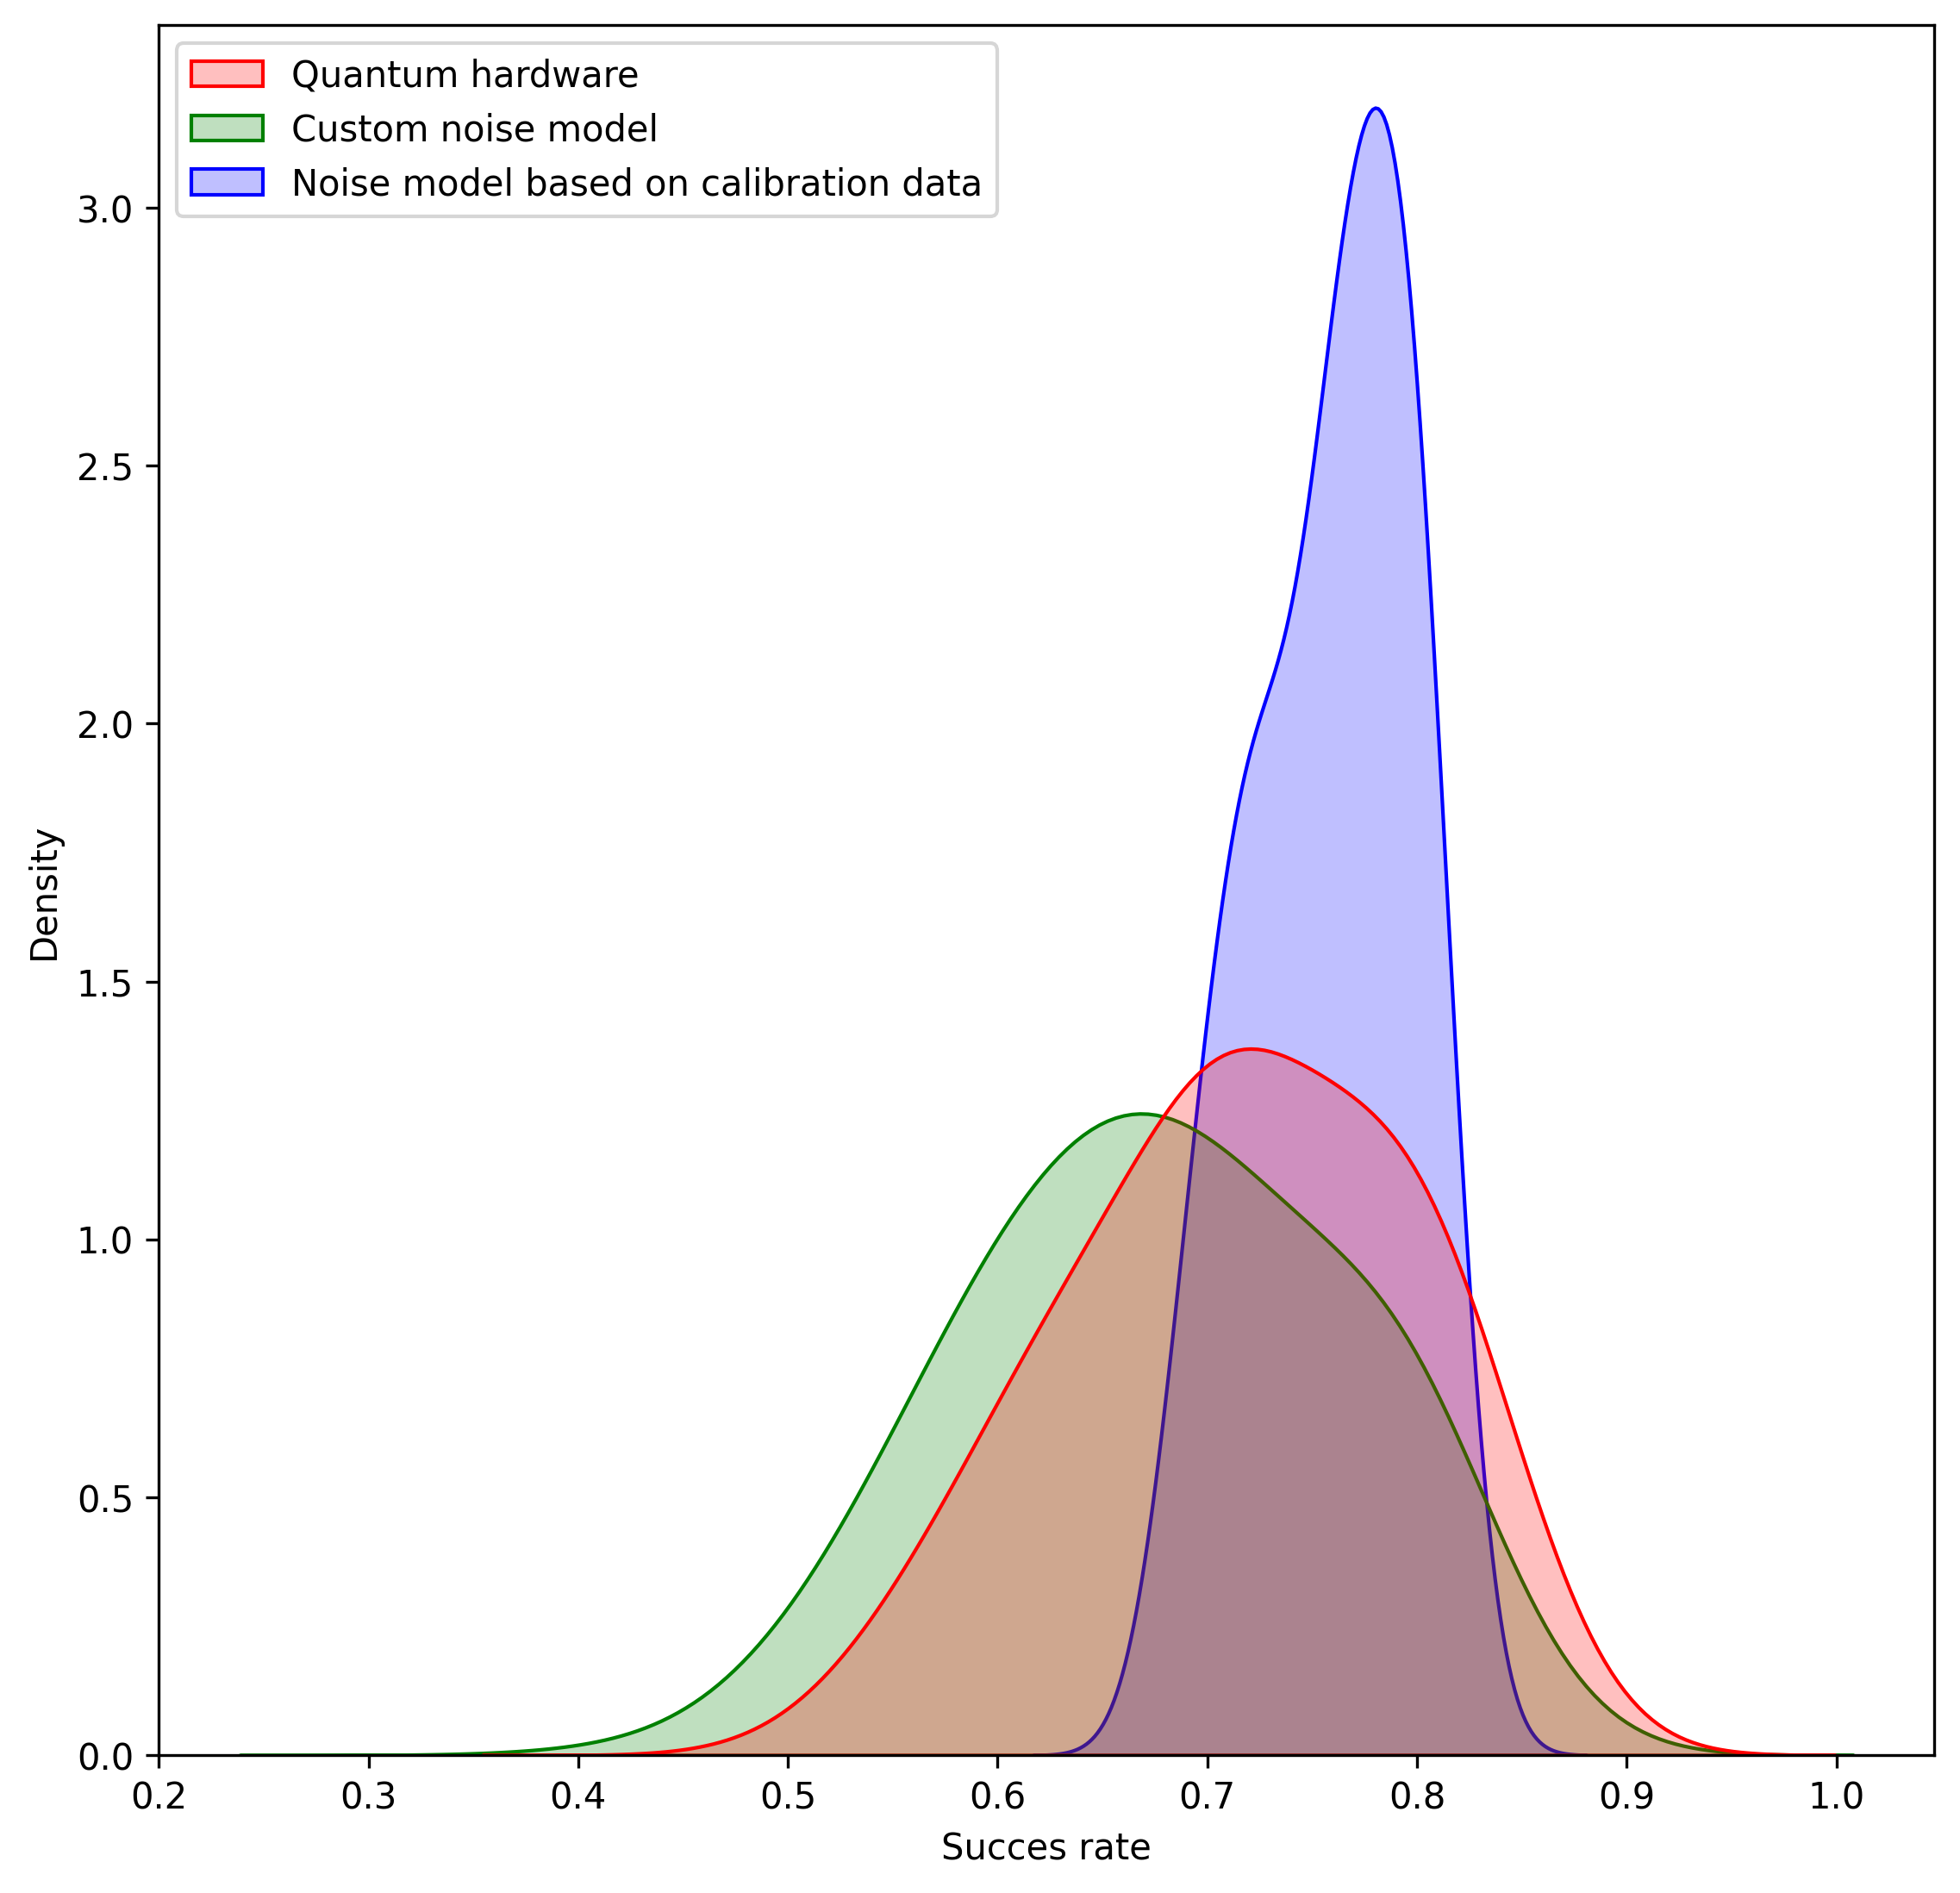

None

In [21]:
def plot(result_dict, name):

	factor = 2.5
	figure_width = 5.90666*factor
	figure_heigth = 5.90666*factor/2
	dpi = 300
	colors = {"sim": "tab:orange",
			  "hw": "r",
			  "custom": "b"}

	figure(figsize=(figure_width, figure_heigth), dpi=dpi)
	plt.plot(result_dict["times"], result_dict["hw_error"].mean(axis=1)*100, label="Hardware", color=colors["hw"])
	plt.plot(result_dict["times"], result_dict["from_backend_err"].mean(axis=1)*100, label="Simulator with noise model based on calibration data", color=colors["sim"])
	plt.plot(result_dict["times"], result_dict["creator_err"].mean(axis=1)*100, label="Simulator using custom noise model", color=colors["custom"])
	plt.yticks(np.arange(50, 101, 5))
	plt.xlabel("Date (day hour)")
	plt.ylabel("Mean success rate")
	plt.legend()
	plt.savefig(f"./images/long_comparison_creator_mean_error_{name}.png", bbox_inches='tight')
	display(plt.show())


	figure(figsize=(figure_width, figure_heigth), dpi=dpi)
	alpha = .2
	plt.fill_between(result_dict["times"], result_dict["hw_error"].min(axis=1)*100, result_dict["hw_error"].max(axis=1)*100, alpha=alpha, label="Hardware", color=colors["hw"])
	plt.fill_between(result_dict["times"], result_dict["creator_err"].min(axis=1)*100, result_dict["creator_err"].max(axis=1)*100, alpha=alpha, label="Custom noise model", color=colors["custom"])
	plt.yticks(np.arange(20, 101, 5))
	plt.xlabel("Date (day hour)")
	plt.ylabel("Success rate")
	plt.legend()
	plt.savefig(f"./images/long_comparison_creator_spread_{name}.png", bbox_inches='tight')
	display(plt.show())

	diff_creator_hw = np.abs(result_dict["creator_err"] - result_dict["hw_error"])*100
	diff_from_backend_hw = np.abs(result_dict["from_backend_err"] - result_dict["hw_error"])*100

	figure(figsize=(figure_width, figure_heigth), dpi=dpi)
	plt.plot(result_dict["times"], diff_creator_hw.mean(axis=1), label="Difference error rate hardware and custom noise model", color=colors["custom"])
	plt.xlabel("Date (day hour)")
	plt.ylabel("Difference percentage points")
	plt.ylim(bottom=0)
	h1, l1 = plt.gca().get_legend_handles_labels()
	second_y = plt.gca().twinx()
	second_y.plot(result_dict["times"], result_dict['time_diff'], label="Time between noise model test circuits and evaluation circuits", color="g")
	second_y.set_ylabel("Time between runs (seconds)")
	h2, l2 = second_y.get_legend_handles_labels()
	plt.legend(h1+h2, l1+l2, loc=2)
	plt.savefig(f"./images/long_comparison_creator_time_between_test_runs{name}.jpg", bbox_inches='tight')
	display(plt.show())

	cleaned_idx = result_dict["time_diff"]<(result_dict["time_diff"].min() * 1.25)
	print(f"time diff min {result_dict['time_diff'].min()}")
	print(f"time diff max {result_dict['time_diff'].max()}")
	cleaned = {k: v[cleaned_idx] for k, v in result_dict.items()}
	cleaned_diff_creator_hw = diff_creator_hw[cleaned_idx]
	cleaned_diff_from_backend_hw = diff_from_backend_hw[cleaned_idx]

	figure(figsize=(figure_width, figure_heigth), dpi=dpi)
	diff = (cleaned_diff_from_backend_hw.mean(axis=1)-cleaned_diff_creator_hw.mean(axis=1))
	plt.plot(cleaned["times"], diff, label="Mean difference between difference from hardware to both noise models")
	plt.axhline(0, color="black")
	top = diff.max()*1.1
	bott = diff.min()*1.1
	plt.axhspan(0, top, color="green", alpha=.3)
	plt.axhspan(0, bott, color="red", alpha=.3)
	plt.ylim(bott, top)
	plt.xlabel("Date (day hour)")
	plt.ylabel("Difference")
	plt.legend()
	plt.savefig(f"./images/long_comparison_creator_relative_{name}.png", bbox_inches='tight')
	display(plt.show())

	print(f"total tests = {diff.shape}")
	print(f"worse = {np.nonzero(diff<0)[0].shape}")
	print(f"diff mean {diff.mean()}")

	correction_factor = (cleaned["creator_err"].mean() - cleaned["hw_error"].mean())
	custom_fixed = cleaned["creator_err"] - correction_factor
	sim_fixed = cleaned["from_backend_err"] - (cleaned["from_backend_err"].mean() - cleaned["hw_error"].mean())


	figure(figsize=(figure_width, figure_heigth), dpi=dpi)
	plt.plot(cleaned["times"], cleaned["hw_error"].mean(axis=1)*100, label="Hardware", color=colors["hw"])
	plt.plot(cleaned["times"], custom_fixed.mean(axis=1)*100, label="Adjusted simulator using custom noise model", color=colors["custom"])

	plt.yticks(np.arange(50, 101, 5))
	plt.xlabel("Date (day hour)")
	plt.ylabel("Mean success rate")
	plt.legend()
	print("diff after fix")
	print(np.abs(custom_fixed - cleaned["hw_error"]).mean()*100)
	print(np.abs(sim_fixed - cleaned["hw_error"]).mean()*100)
	plt.savefig(f"./images/long_comparison_creator_mean_error_fixed_{name}.png", bbox_inches='tight')
	display(plt.show())

	factor = 3
	figure_width = 5.90666*factor/2
	figure_heigth = figure_width
	dpi = 300

	figure(figsize=(figure_width, figure_heigth), dpi=dpi)
	data = pd.DataFrame({"Quantum hardware": cleaned["hw_error"].flatten(), "Custom noise model": cleaned["creator_err"].flatten(), "Noise model based on calibration data": cleaned["from_backend_err"].flatten()})
	ax = sns.kdeplot(data=data, palette=["red", "green", "blue"], bw_adjust=3, fill=True)
	sns.move_legend(ax, "upper left")
	plt.xlabel("Succes rate")
	plt.savefig(f"./images/long_comparison_creator_mean_error_distribution_{name}.png", bbox_inches='tight')
	display(plt.show())

plot(ibmq_manila, "ibmq_manila")
plot(ibmq_quito, "ibmq_quito")